In [2]:
import numpy as np
import pandas as pd 
import re
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (
    export_graphviz,
    DecisionTreeClassifier,
    DecisionTreeRegressor
)
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay, 
    recall_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedShuffleSplit,
    cross_val_score,
    RandomizedSearchCV
)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


keywords = ["auto","construct","capital_market","chemicals","equipment",
            "transport","semi","bank","steel",
            "telecom","staples","discretionary","kospi"]


In [3]:
dfs = {}  # 빈 딕셔너리 생성
column_names_per_keyword = {}

# 각 키워드에 해당하는 데이터프레임을 dfs 딕셔너리에 추가
for keyword in keywords:
    dfs[keyword] = pd.read_excel('0703_total.xlsx', sheet_name=keyword, header=0, index_col=0)
    column_names_per_keyword[keyword] = dfs[keyword].columns.tolist()

    print(f"Compile {keyword}")

# 각 데이터프레임의 인덱스를 날짜 형식으로 변환한 후 문자열로 변경
for keyword, df in dfs.items():
    df.index = pd.to_datetime(df.index)
    df.index = df.index.strftime('%Y-%m-%d')

# 첫 2개 행을 출력
for keyword, df in dfs.items():
    print(f"Top 2 rows of {keyword}:")
    print(df.head(2))
    print(column_names_per_keyword[keyword])


Compile auto
Compile construct
Compile capital_market
Compile chemicals
Compile equipment
Compile transport
Compile semi
Compile bank
Compile steel
Compile telecom
Compile staples
Compile discretionary
Compile kospi
Top 2 rows of auto:
             auto    WTI  DGS2  DGS10  TIPS    VIX    PPI    per   pbr  \
date                                                                     
2010-04-07  S_buy  85.64  1.06   3.89  1.55  16.62  172.2  24.26  1.39   
2010-04-08  S_buy  85.17  1.09   3.91  1.58  16.48  172.2  24.42  1.39   

               원달러  ...   구리선물_60  중국고정자산투자(yoy%)_60  중국 PMI_60   금 선물_60  \
date                ...                                                     
2010-04-07  1120.5  ...  0.001518          -0.003370  -0.001632  0.000112   
2010-04-08  1123.3  ...  0.001700          -0.003414  -0.001553  0.000216   

            달러 인덱스_60  중국 소매판매_60  중국 산업 생산_60  MSCI_EMER_60  US_auto_60  \
date                                                                       
2010-0

In [4]:
data_splits = {}
last_rows = {}  # 각 키워드의 마지막 행을 저장할 딕셔너리

for keyword, df_index in dfs.items():
    # 각 키워드의 마지막 행 추출 및 저장
    last_row = df_index.iloc[-1]  # 마지막 행 저장
    last_rows[keyword] = last_row  # 추출된 마지막 행을 저장
    
    df_dropna = df_index.dropna()  # 결측치가 있는 행 제거
    
    if df_dropna.empty:
        print(f"Error: Dataframe for {keyword} is empty.")
    else:
        # 종속 변수(y) 및 독립 변수(X) 설정
        y_keyword = df_dropna[keyword]  # 현재 키워드에 해당하는 종속 변수
        X_keyword = df_dropna.drop(columns=[keyword])  # 현재 키워드를 제외한 나머지 열은 독립 변수로 사용

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(X_keyword, y_keyword, test_size=0.2, random_state=0)
        
        # 데이터 정규화
        normalizer = StandardScaler()
        X_train_normalized = normalizer.fit_transform(X_train)
        X_test_normalized = normalizer.transform(X_test)

        # 데이터 저장
        data_splits[keyword] = {
            'X_train': X_train_normalized,
            'X_test': X_test_normalized,
            'y_train': y_train,
            'y_test': y_test
        }

        print(f'Train set dimension for {keyword} is {X_train_normalized.shape}')
        print(f'Test set dimension for {keyword} is {X_test_normalized.shape}')
        # 훈련 데이터와 테스트 데이터의 클래스 비율 확인
        train_class_counts = {label: sum(y_train == label) for label in set(y_keyword)}
        test_class_counts = {label: sum(y_test == label) for label in set(y_keyword)}

        print(f"훈련 데이터 클래스 비율 for {keyword}:", train_class_counts)
        print(f"테스트 데이터 클래스 비율 for {keyword}:", test_class_counts)


Train set dimension for auto is (2535, 87)
Test set dimension for auto is (634, 87)
훈련 데이터 클래스 비율 for auto: {'S_buy': 607, 'sell': 1219, 'buy': 709}
테스트 데이터 클래스 비율 for auto: {'S_buy': 143, 'sell': 321, 'buy': 170}
Train set dimension for construct is (2535, 87)
Test set dimension for construct is (634, 87)
훈련 데이터 클래스 비율 for construct: {'S_buy': 705, 'sell': 1240, 'buy': 590}
테스트 데이터 클래스 비율 for construct: {'S_buy': 162, 'sell': 338, 'buy': 134}
Train set dimension for capital_market is (2535, 87)
Test set dimension for capital_market is (634, 87)
훈련 데이터 클래스 비율 for capital_market: {'S_buy': 634, 'sell': 1250, 'buy': 651}
테스트 데이터 클래스 비율 for capital_market: {'S_buy': 146, 'sell': 343, 'buy': 145}
Train set dimension for chemicals is (2535, 87)
Test set dimension for chemicals is (634, 87)
훈련 데이터 클래스 비율 for chemicals: {'S_buy': 644, 'sell': 1198, 'buy': 693}
테스트 데이터 클래스 비율 for chemicals: {'S_buy': 146, 'sell': 311, 'buy': 177}
Train set dimension for equipment is (2535, 87)
Test set dimensi

In [5]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

# 각 키워드에 대한 최고 성능 모델과 정확도를 저장할 딕셔너리
best_models = {}
best_accuracies = {}

def train_and_evaluate(keyword, data_split):
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    y_test = data_split['y_test']
    
    accuracies = {}  # 키워드마다 새로운 accuracies 딕셔너리 생성

    random_forest = RandomForestClassifier()
    gradient_boosting = GradientBoostingClassifier()
    svm = SVC()
    knn = KNeighborsClassifier()
    decision_tree = DecisionTreeClassifier()

    # Voting Classifier 생성
    voting_classifier = VotingClassifier(
        estimators=[
            ('rf', random_forest), 
            ('gb', gradient_boosting), 
            ('svm', svm), 
            ('knn', knn),
            ('dt', decision_tree)
        ],
        voting='hard'
    )

    models = {
        'Random Forest': random_forest,
        'Gradient Boosting': gradient_boosting,
        'Support Vector Machine': svm,
        'K-Nearest Neighbors': knn,
        'Decision Tree': decision_tree,
        'Voting Classifier': voting_classifier
    }

    # 각 분류기에 대해 학습하고 평가
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[name] = accuracy

    # 가장 높은 정확도를 가진 모델 찾기
    best_model_name = max(accuracies, key=accuracies.get)
    best_accuracy = accuracies[best_model_name]
    
    return keyword, best_model_name, best_accuracy

results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(keyword, data_split) for keyword, data_split in data_splits.items())

# 결과 저장 및 출력
for keyword, best_model_name, best_accuracy in results:
    best_models[keyword] = best_model_name
    best_accuracies[keyword] = best_accuracy
    print(f"{keyword}에서 최고의 성능을 보인 모델은 {best_model_name}로, 정확도는 {best_accuracy:.3f}입니다.")

def print_best_model(keyword):
    best_model_name = best_models.get(keyword)
    if best_model_name:
        accuracy = best_accuracies.get(keyword)
        print(f"Best model for {keyword} is {best_model_name} with accuracy {accuracy:.3f}")

# 각 키워드별 최고 성능의 모델 출력
for keyword in data_splits.keys():
    print_best_model(keyword)


auto에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.852입니다.
construct에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.823입니다.
capital_market에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.855입니다.
chemicals에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.836입니다.
equipment에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.841입니다.
transport에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.830입니다.
semi에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.808입니다.
bank에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.831입니다.
steel에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.831입니다.
telecom에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.855입니다.
staples에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.869입니다.
discretionary에서 최고의 성능을 보인 모델은 Random Forest로, 정확도는 0.838입니다.
kospi에서 최고의 성능을 보인 모델은 K-Nearest Neighbors로, 정확도는 0.858입니다.
Best model for auto is Random Forest with accuracy 0.852
Best model for construct is Random Forest with accuracy 0.823
Best model for capital_market is Random Forest with accuracy 0.855
Best model for chemicals is Random Forest with accuracy 0.836
Best model

In [6]:
# Train set 및 Test set에 대한 성능을 저장할 딕셔너리 생성
performance_results = {}

# Random Forest 모델 생성
rfc = RandomForestClassifier()

# 각 키워드에 대해 모델을 학습하고 Train set 및 Test set에 대한 성능을 측정
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    X_test = data_split['X_test']
    y_test = data_split['y_test']
    
    # 모델 학습
    rfc.fit(X_train, y_train)

    # Train set에 대한 성능 측정
    y_pred_train = rfc.predict(X_train)
    acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)

    # Test set에 대한 성능 측정
    y_pred_test = rfc.predict(X_test)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)

    # 결과 저장
    performance_results[keyword] = {
        'Train 성능': acc_train,
        'Test 성능': acc_test
    }

# 각 키워드에 대한 Train set 및 Test set의 성능 출력
for keyword, performance in performance_results.items():
    print(f"{keyword} 키워드에 대한 성능: ", performance['Test 성능'])
    print()


auto 키워드에 대한 성능:  0.8422712933753943

construct 키워드에 대한 성능:  0.8233438485804416

capital_market 키워드에 대한 성능:  0.862776025236593

chemicals 키워드에 대한 성능:  0.831230283911672

equipment 키워드에 대한 성능:  0.8343848580441641

transport 키워드에 대한 성능:  0.8233438485804416

semi 키워드에 대한 성능:  0.807570977917981

bank 키워드에 대한 성능:  0.8391167192429022

steel 키워드에 대한 성능:  0.8280757097791798

telecom 키워드에 대한 성능:  0.8580441640378549

staples 키워드에 대한 성능:  0.8580441640378549

discretionary 키워드에 대한 성능:  0.8217665615141956

kospi 키워드에 대한 성능:  0.8675078864353313



C:\Users\user\AppData\Local\Temp\ipykernel_37352\776093913.py:30: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37352\776093913.py:30: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37352\776093913.py:30: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37352\776093913.py:30: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37352\776093913.py:30: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37352\776093913.py:30: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaV

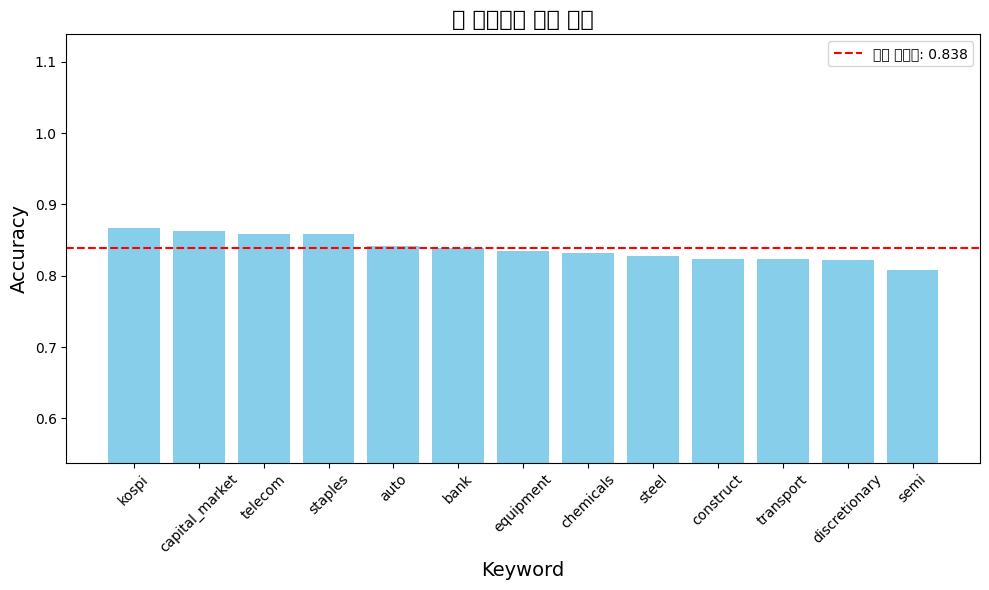

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Train set 및 Test set에 대한 성능 추출
keywords = list(performance_results.keys())
train_accuracies = [performance['Train 성능'] for performance in performance_results.values()]
test_accuracies = [performance['Test 성능'] for performance in performance_results.values()]

# 성능을 내림차순으로 정렬
sorted_indices = sorted(range(len(test_accuracies)), key=lambda i: test_accuracies[i], reverse=True)
sorted_keywords = [keywords[i] for i in sorted_indices]
sorted_test_accuracies = [test_accuracies[i] for i in sorted_indices]

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.bar(sorted_keywords, sorted_test_accuracies, color='skyblue')
plt.xlabel('Keyword', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('각 키워드에 대한 성능', fontsize=16)
plt.xticks(rotation=45)

# 정확도 평균 계산
mean_accuracy = np.mean(sorted_test_accuracies)
plt.axhline(y=mean_accuracy, color='red', linestyle='--', label=f'평균 정확도: {mean_accuracy:.3f}')

# y축 범위 조정하여 확대
plt.ylim(mean_accuracy - 0.3, mean_accuracy + 0.3)

plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


auto 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 19 입니다.
construct 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 20 입니다.
capital_market 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 17 입니다.
chemicals 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 18 입니다.
equipment 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 14 입니다.
transport 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 20 입니다.
semi 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 18 입니다.
bank 키워드에 대한 최적의 트리 수는 18, 최적의 깊이는 20 입니다.
steel 키워드에 대한 최적의 트리 수는 14, 최적의 깊이는 20 입니다.
telecom 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 20 입니다.
staples 키워드에 대한 최적의 트리 수는 20, 최적의 깊이는 13 입니다.
discretionary 키워드에 대한 최적의 트리 수는 19, 최적의 깊이는 16 입니다.
kospi 키워드에 대한 최적의 트리 수는 16, 최적의 깊이는 13 입니다.


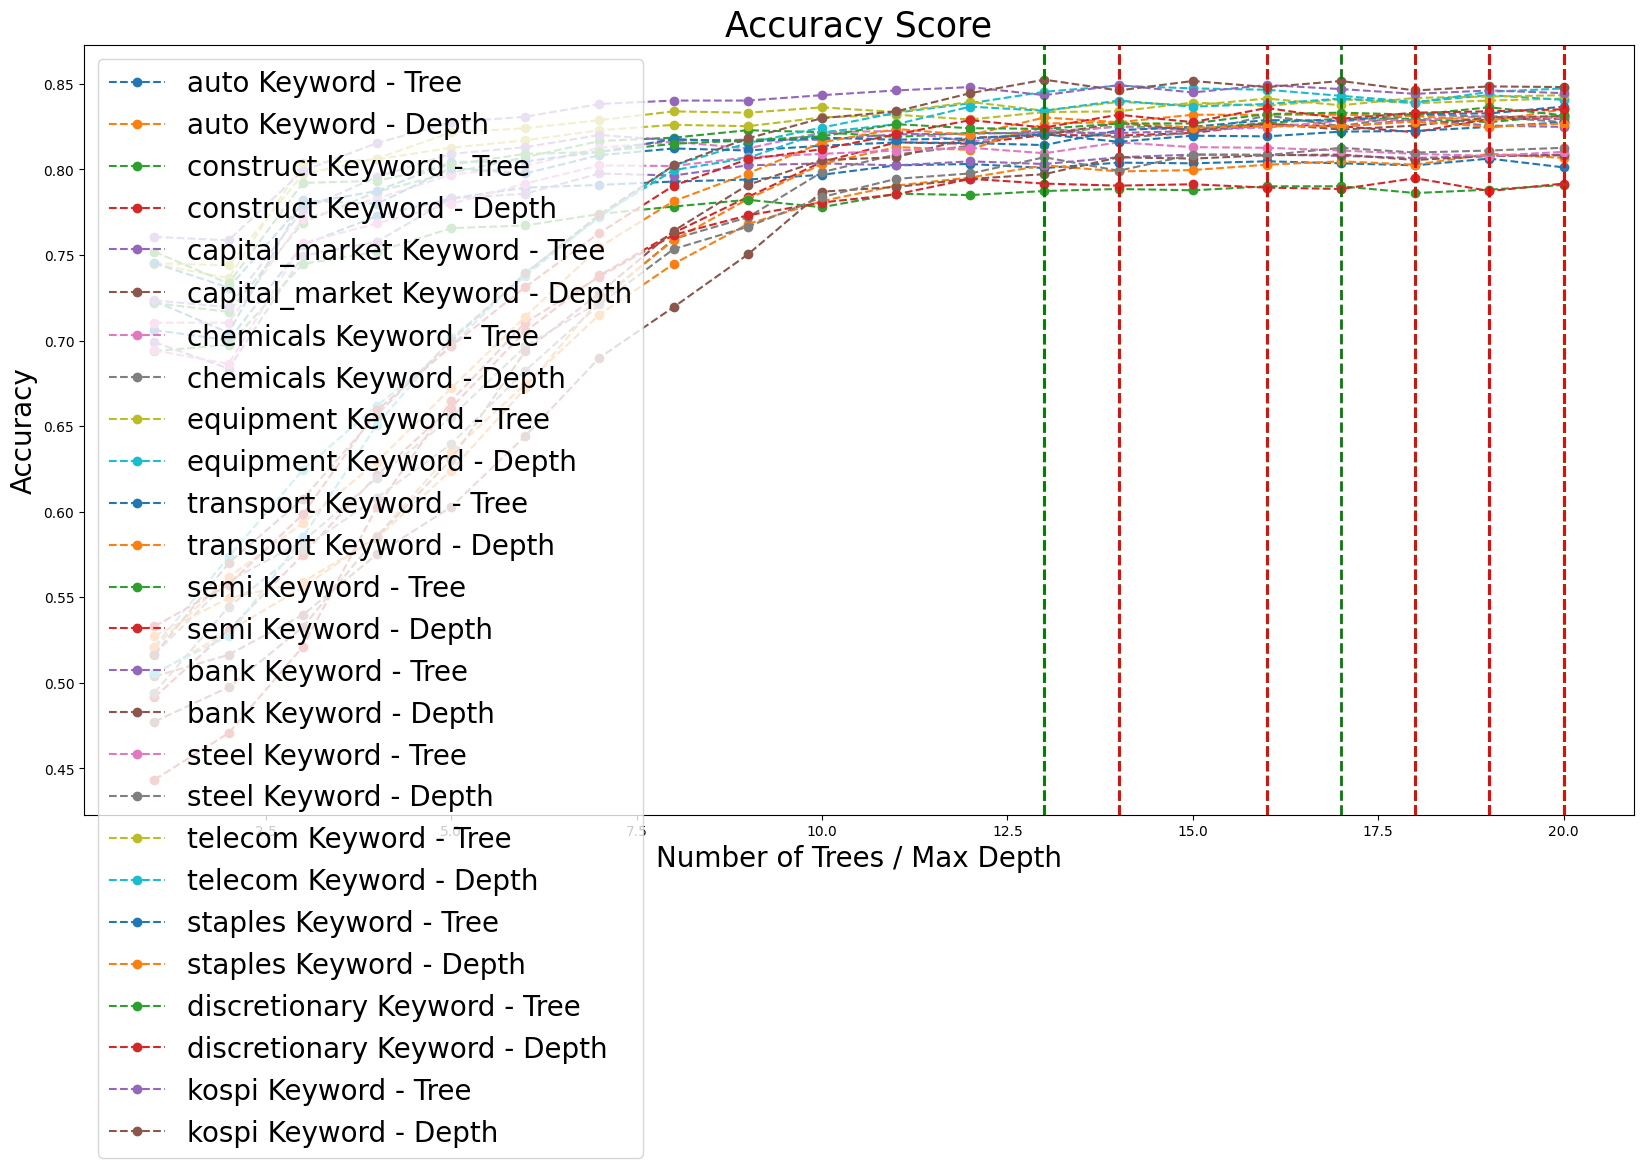

In [8]:
estimator_list = list(range(1, 21))  # 1부터 20까지의 값을 가지는 리스트
depth_list = list(range(1, 21))  # 1부터 20까지의 값을 가지는 리스트
cv_scores_per_keyword = {}  # 각 키워드에 대한 교차 검증 점수를 저장할 딕셔너리
best_estimators_per_keyword = {}  # 각 키워드에 대한 최적의 트리 수를 저장할 딕셔너리
best_depths_per_keyword = {}  # 각 키워드에 대한 최적의 깊이를 저장할 딕셔너리

for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    
    cv_scores = []  # 교차 검증 점수를 저장할 리스트
    cv_scores_depth = []  # 교차 검증 점수를 저장할 리스트
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=i+1,
                                     max_leaf_nodes=300,
                                     n_jobs=-1,
                                     random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores.append(score)

    best_estimator = estimator_list[np.argmax(cv_scores)]
    best_estimators_per_keyword[keyword] = best_estimator
    
    for i in tqdm(range(20)):
        rfc = RandomForestClassifier(n_estimators=best_estimator,
                                     max_depth=i+1,
                                     max_leaf_nodes=300,
                                     n_jobs=-1,
                                     random_state=0)
        score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
        cv_scores_depth.append(score)

    best_depth = depth_list[np.argmax(cv_scores_depth)]
    best_depths_per_keyword[keyword] = best_depth
    
    # 교차 검증 점수를 딕셔너리에 저장
    cv_scores_per_keyword[keyword] = {'tree_scores': cv_scores, 'depth_scores': cv_scores_depth}

# 각 키워드에 대한 최적의 트리 수와 깊이 출력
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    print(f"{keyword} 키워드에 대한 최적의 트리 수는 {best_estimator}, 최적의 깊이는 {best_depth} 입니다.")

# 각 키워드에 대한 교차 검증 점수 시각화
plt.figure(figsize=(20, 10))
for keyword, scores in cv_scores_per_keyword.items():
    plt.plot(estimator_list, scores['tree_scores'], marker='o', linestyle='dashed', label=f"{keyword} Keyword - Tree")
    plt.plot(depth_list, scores['depth_scores'], marker='o', linestyle='dashed', label=f"{keyword} Keyword - Depth")
plt.legend(fontsize=20)
plt.xlabel("Number of Trees / Max Depth", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]
    plt.axvline(best_estimator, color='r', linestyle='--', linewidth=2)
    plt.axvline(best_depth, color='g', linestyle='--', linewidth=2)
plt.show()


In [9]:
for keyword, data_split in data_splits.items():

    # 교차 검증
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=5)
    print(f"{keyword} 교차 검증 점수: {cv_scores}")
    print(f"{keyword} 교차 검증 평균 점수: {cv_scores.mean()}")

auto 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
auto 교차 검증 평균 점수: 0.8520710059171599
construct 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
construct 교차 검증 평균 점수: 0.8520710059171599
capital_market 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
capital_market 교차 검증 평균 점수: 0.8520710059171599
chemicals 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
chemicals 교차 검증 평균 점수: 0.8520710059171599
equipment 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
equipment 교차 검증 평균 점수: 0.8520710059171599
transport 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
transport 교차 검증 평균 점수: 0.8520710059171599
semi 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
semi 교차 검증 평균 점수: 0.8520710059171599
bank 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220907]
bank 교차 검증 평균 점수: 0.8520710059171599
steel 교차 검증 점수: [0.85207101 0.86193294 0.86982249 0.83431953 0.84220

auto 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8461
auto 키워드에 대한 Test set에 대한 성능
정확도: 0.8644

민감도: 0.8478
정밀도: 0.8644


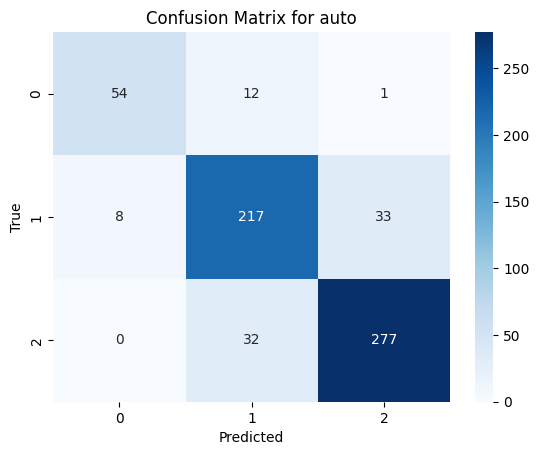

construct 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8418
construct 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8468
정밀도: 0.8595


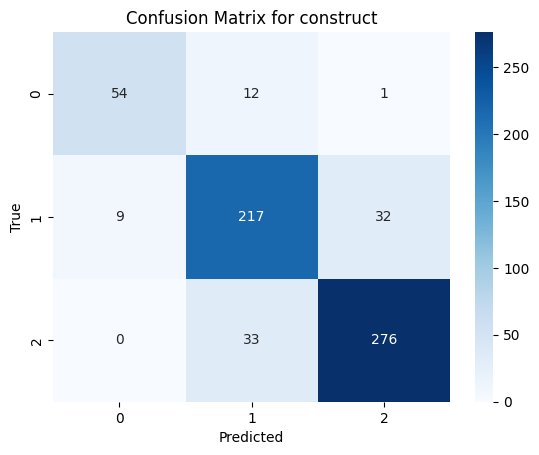

capital_market 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8485
capital_market 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8461
정밀도: 0.8596


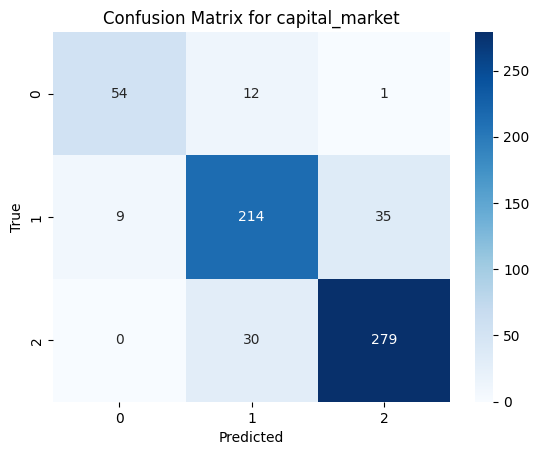

chemicals 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8481
chemicals 키워드에 대한 Test set에 대한 성능
정확도: 0.8612

민감도: 0.8455
정밀도: 0.8620


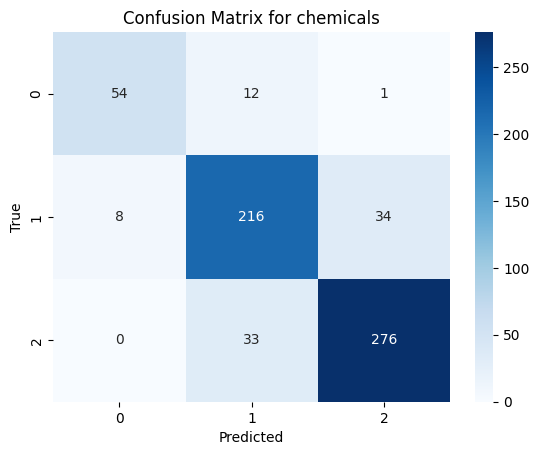

equipment 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8497
equipment 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8385
정밀도: 0.8620


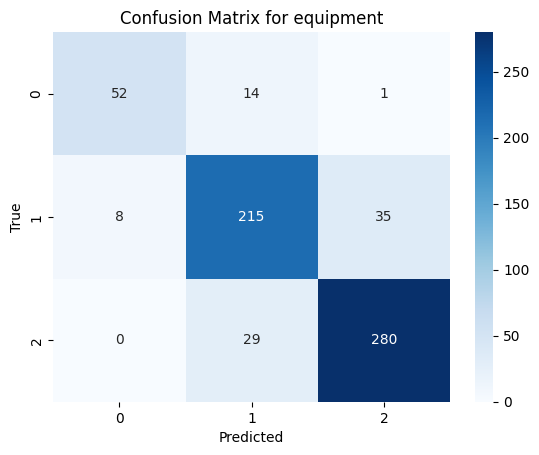

transport 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8418
transport 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8468
정밀도: 0.8595


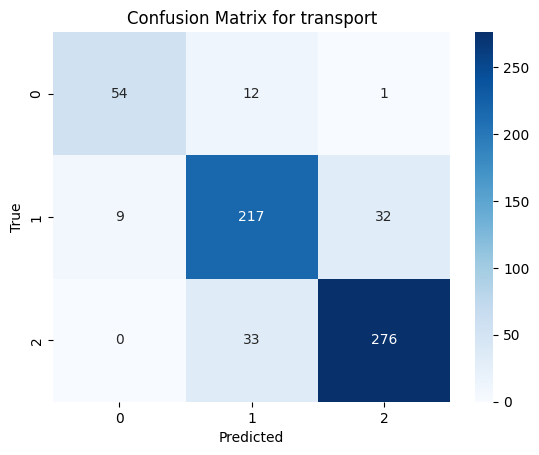

semi 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8477
semi 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8465
정밀도: 0.8595


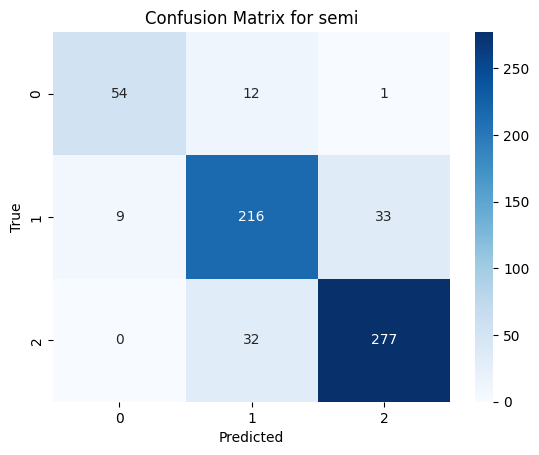

bank 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8442
bank 키워드에 대한 Test set에 대한 성능
정확도: 0.8722

민감도: 0.8621
정밀도: 0.8788


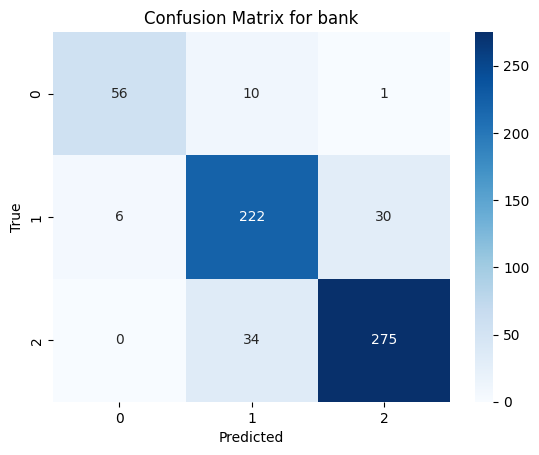

steel 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8469
steel 키워드에 대한 Test set에 대한 성능
정확도: 0.8675

민감도: 0.8508
정밀도: 0.8706


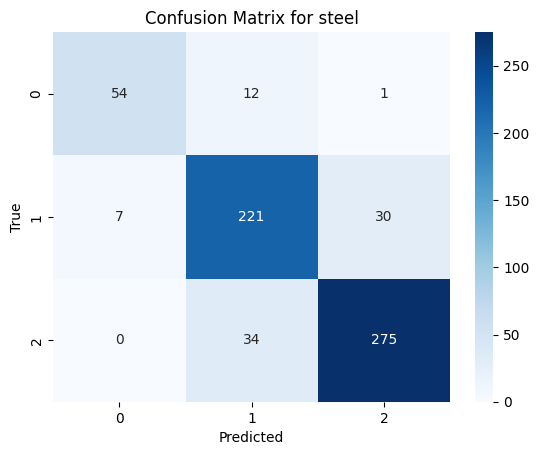

telecom 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8418
telecom 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8468
정밀도: 0.8595


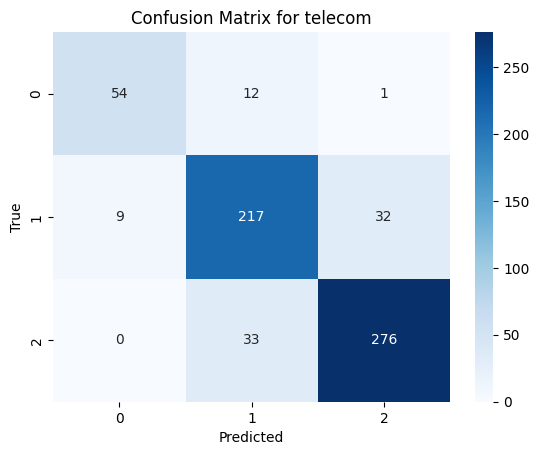

staples 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8489
staples 키워드에 대한 Test set에 대한 성능
정확도: 0.8612

민감도: 0.8340
정밀도: 0.8602


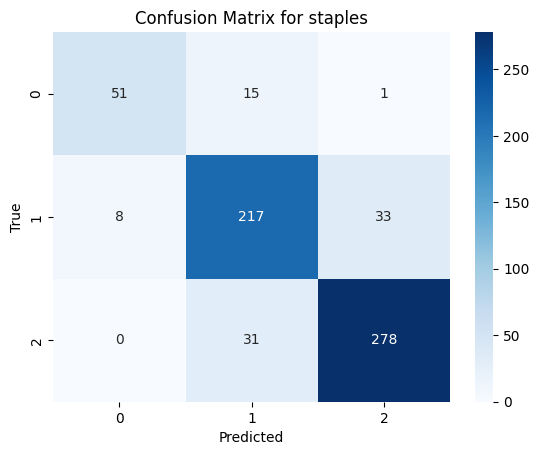

discretionary 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8501
discretionary 키워드에 대한 Test set에 대한 성능
정확도: 0.8644

민감도: 0.8476
정밀도: 0.8538


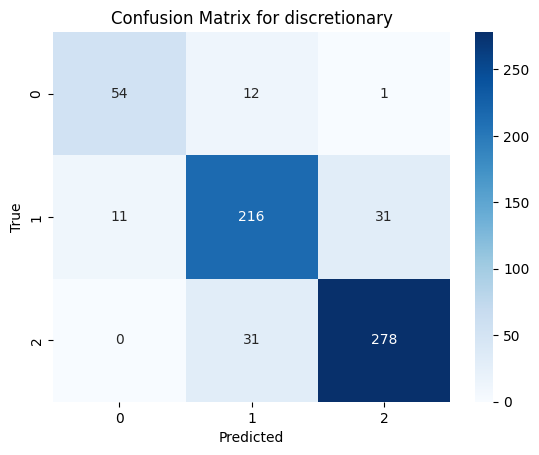

kospi 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)
평균 정확도: 0.8524
kospi 키워드에 대한 Test set에 대한 성능
정확도: 0.8628

민감도: 0.8346
정밀도: 0.8656


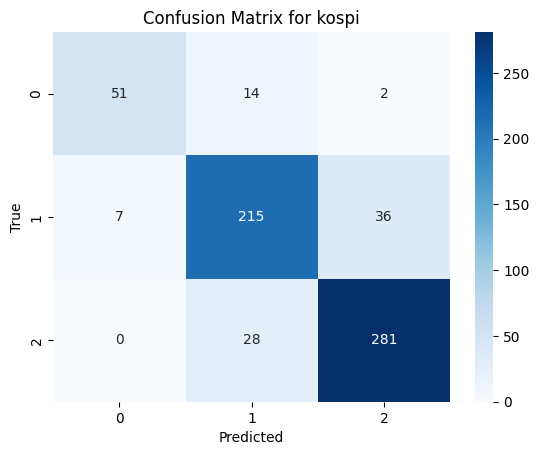

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 각 키워드별 최적의 트리 개수와 최적의 깊이 출력
for keyword in data_splits.keys():
    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # 최적의 트리 개수와 깊이를 사용하여 RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    # 교차 검증을 통한 정확도 측정
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')

    # 평균 정확도 출력
    print(f"{keyword} 키워드에 대한 Train set에 대한 성능 (10 fold cross validation)")
    print(f"평균 정확도: {cv_scores.mean():.4f}")

    # Train set에 대한 최적의 모델 학습
    rfc.fit(X_train, y_train)

    # Test set에 대한 예측값 생성
    y_pred = rfc.predict(X_test)

    # Test set에 대한 정확도 계산 및 출력
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"{keyword} 키워드에 대한 Test set에 대한 성능")
    print(f"정확도: {acc_test:.4f}\n")

    # Test set에 대한 민감도와 정밀도 계산
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')

    # 민감도와 정밀도 출력
    print(f"민감도: {recall:.4f}")
    print(f"정밀도: {precision:.4f}")

    # 혼동 행렬 생성
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {keyword}')
    plt.show()


auto 키워드의 상위 5개 특성:
Feature Name: per_60, Importance: 0.0221
Feature Name: 중국 산업 생산_60, Importance: 0.0212
Feature Name: export_60, Importance: 0.0207
Feature Name: MSCI_EMER_60, Importance: 0.0205
Feature Name: DGS2, Importance: 0.0193

auto 키워드의 하위 5개 특성:
Feature Name: cpi, Importance: 0.0064
Feature Name: 중국고정자산투자(yoy%), Importance: 0.0063
Feature Name: 달러 인덱스, Importance: 0.0055
Feature Name: yield_gap(%), Importance: 0.0052
Feature Name: T10Y2Y, Importance: 0.0029

construct 키워드의 상위 5개 특성:
Feature Name: TIPS, Importance: 0.0203
Feature Name: 구리선물_60, Importance: 0.0201
Feature Name: 중국 산업 생산, Importance: 0.0201
Feature Name: 원달러_60, Importance: 0.0198
Feature Name: export_60, Importance: 0.0185

construct 키워드의 하위 5개 특성:
Feature Name: MSCI_EMER_20, Importance: 0.0058
Feature Name: 구리선물, Importance: 0.0050
Feature Name: per, Importance: 0.0049
Feature Name: MSCI_EMER, Importance: 0.0045
Feature Name: T10Y2Y, Importance: 0.0036

capital_market 키워드의 상위 5개 특성:
Feature Name: 구리선물_60, Im

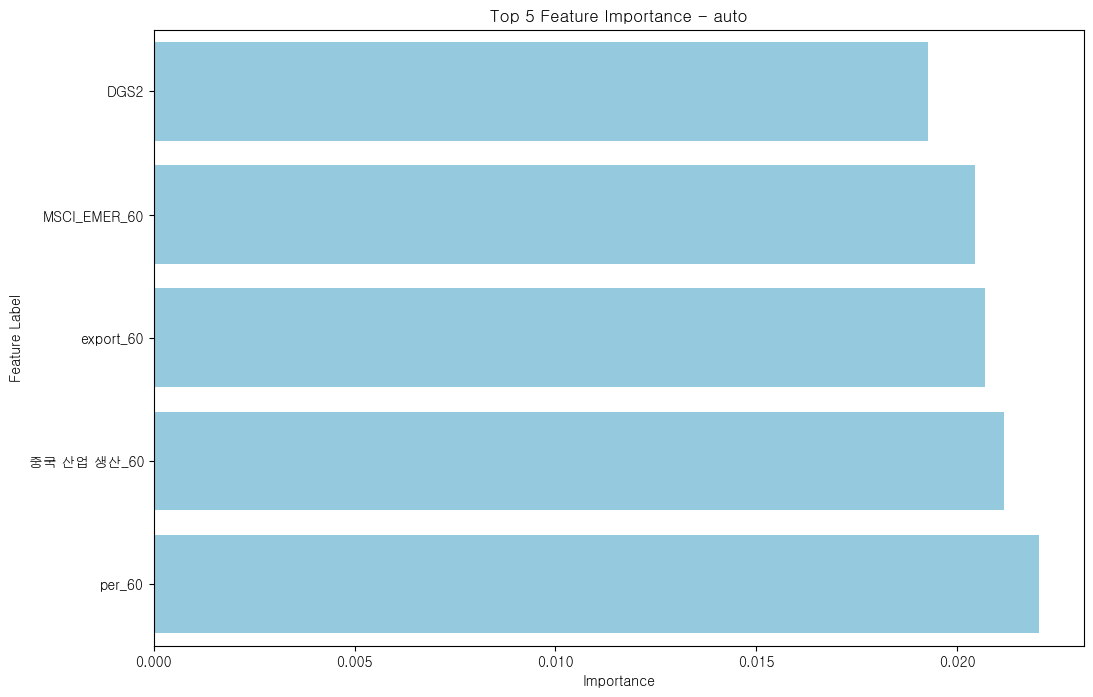

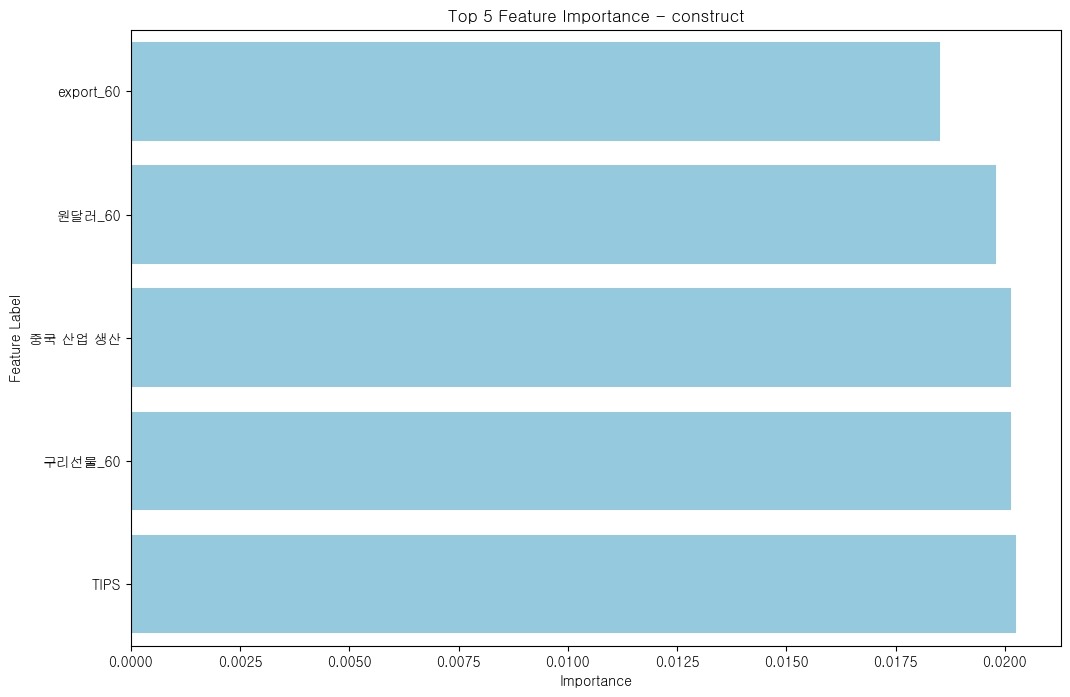

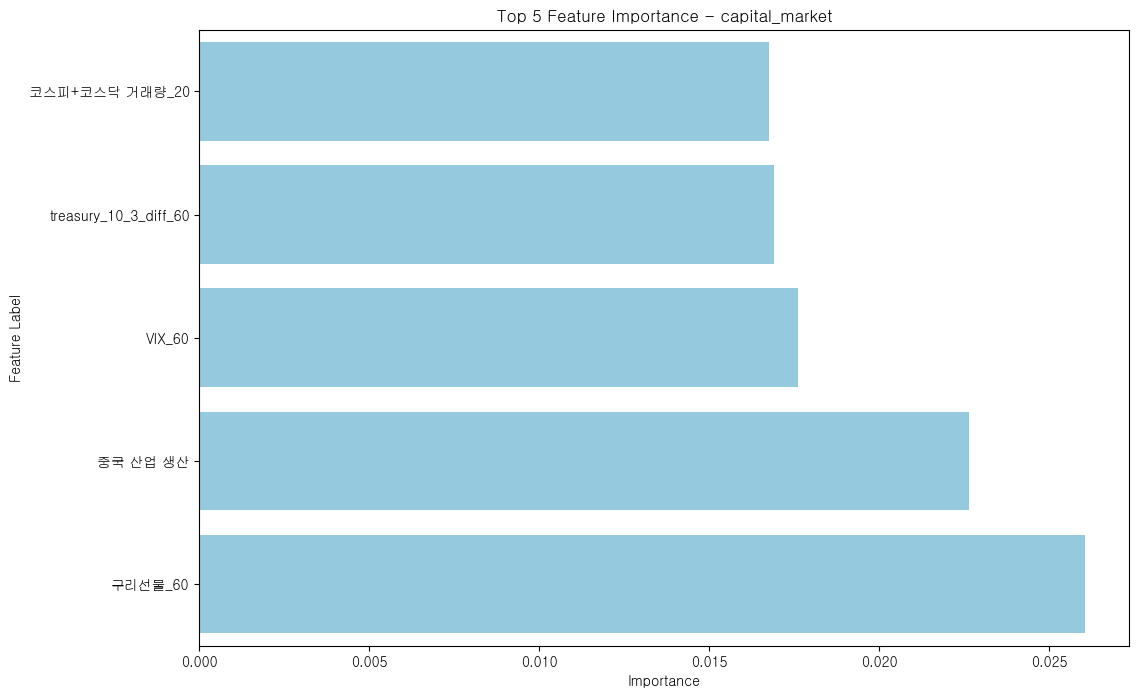

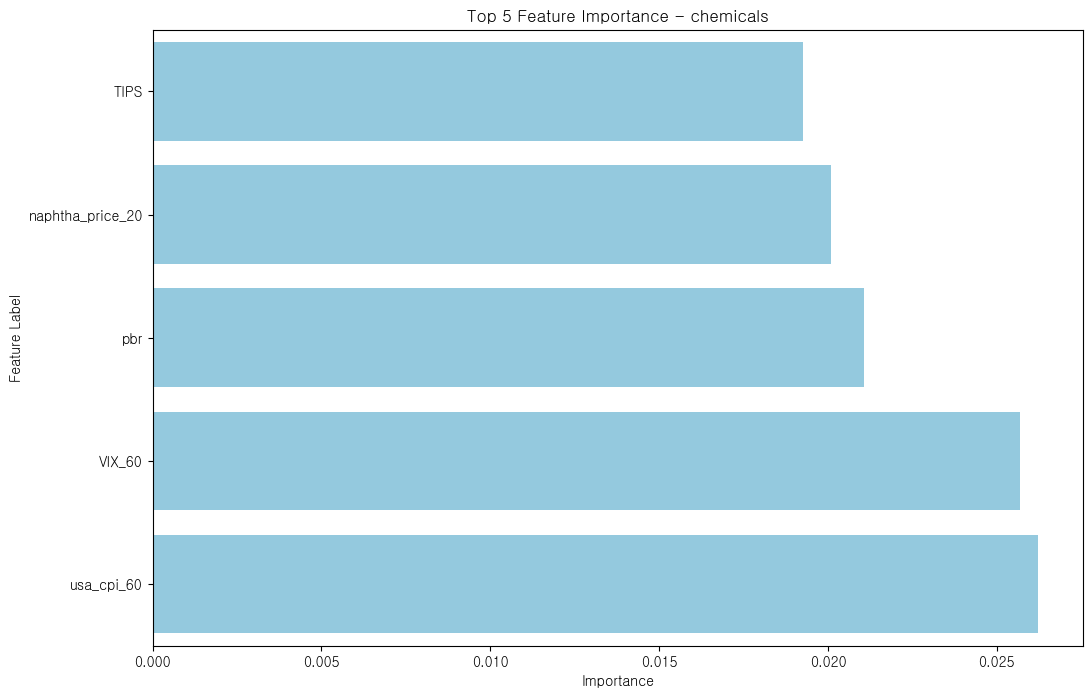

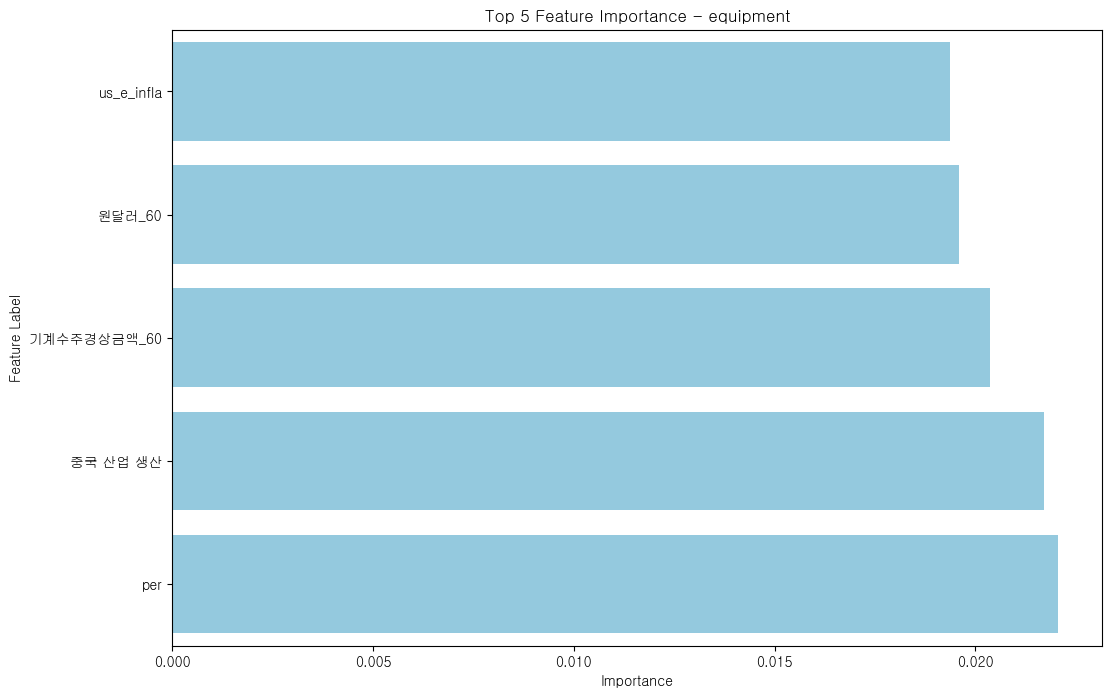

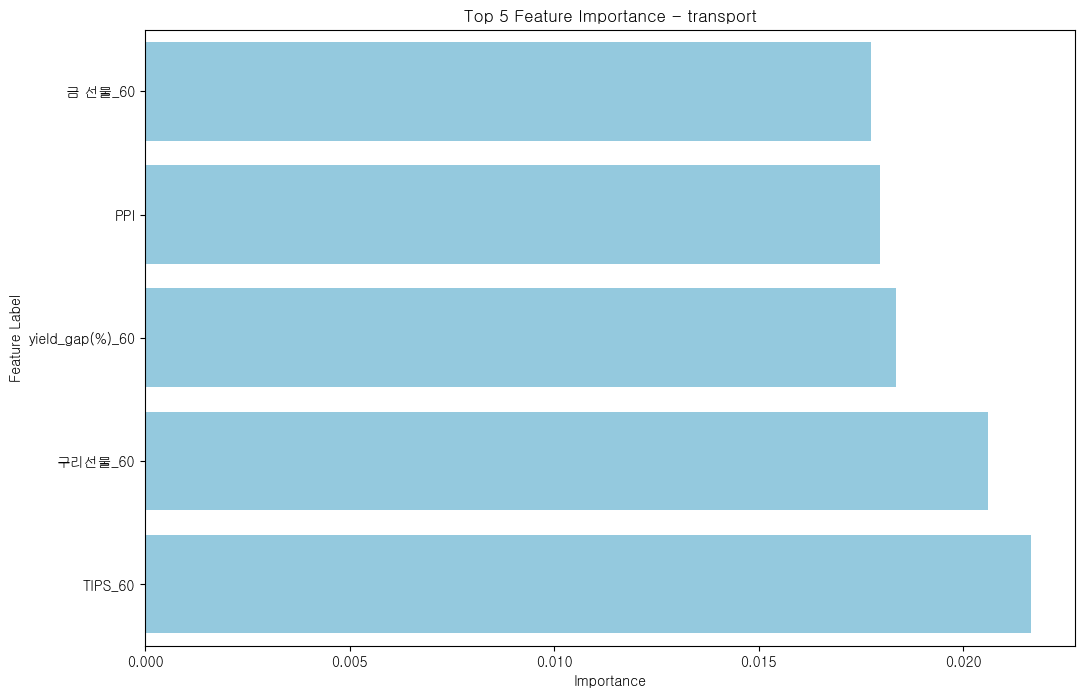

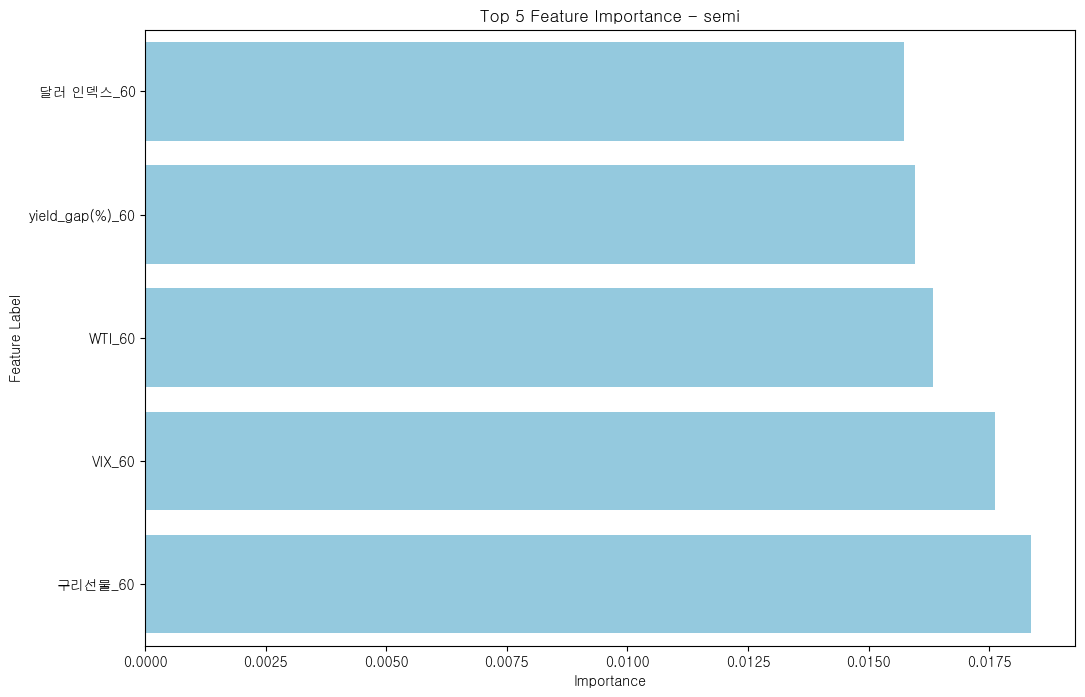

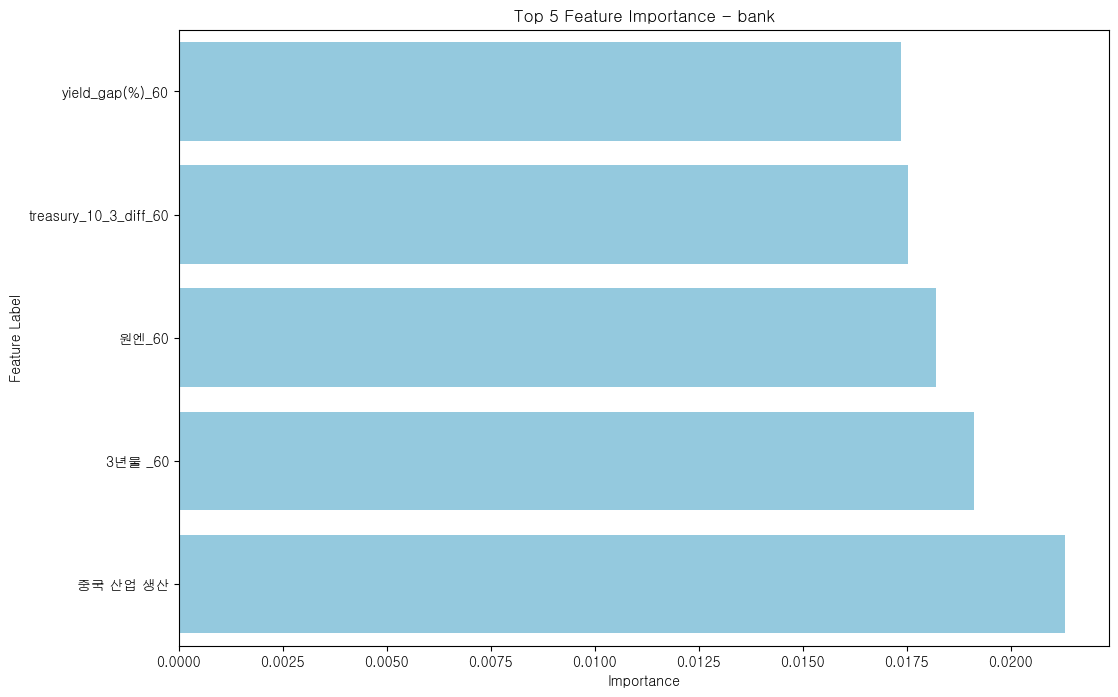

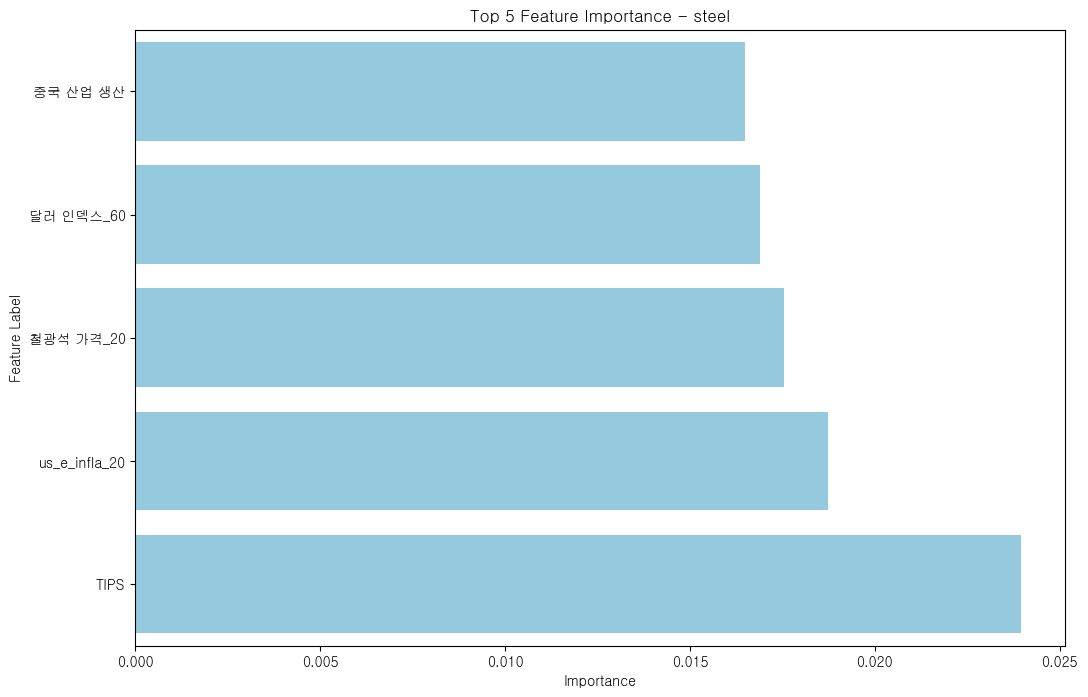

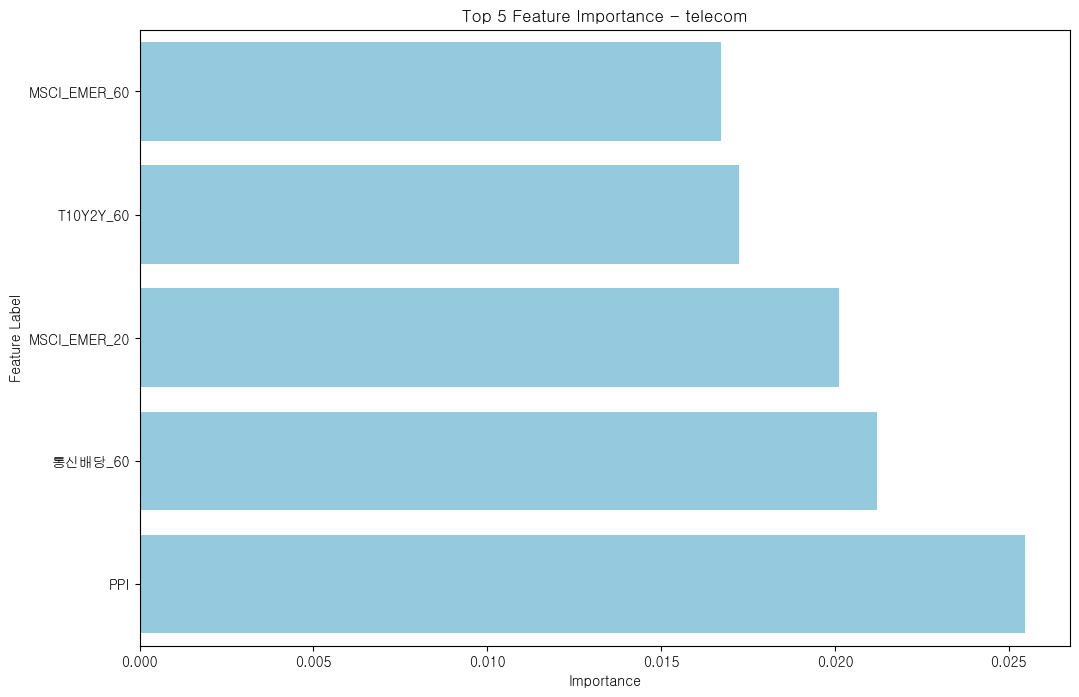

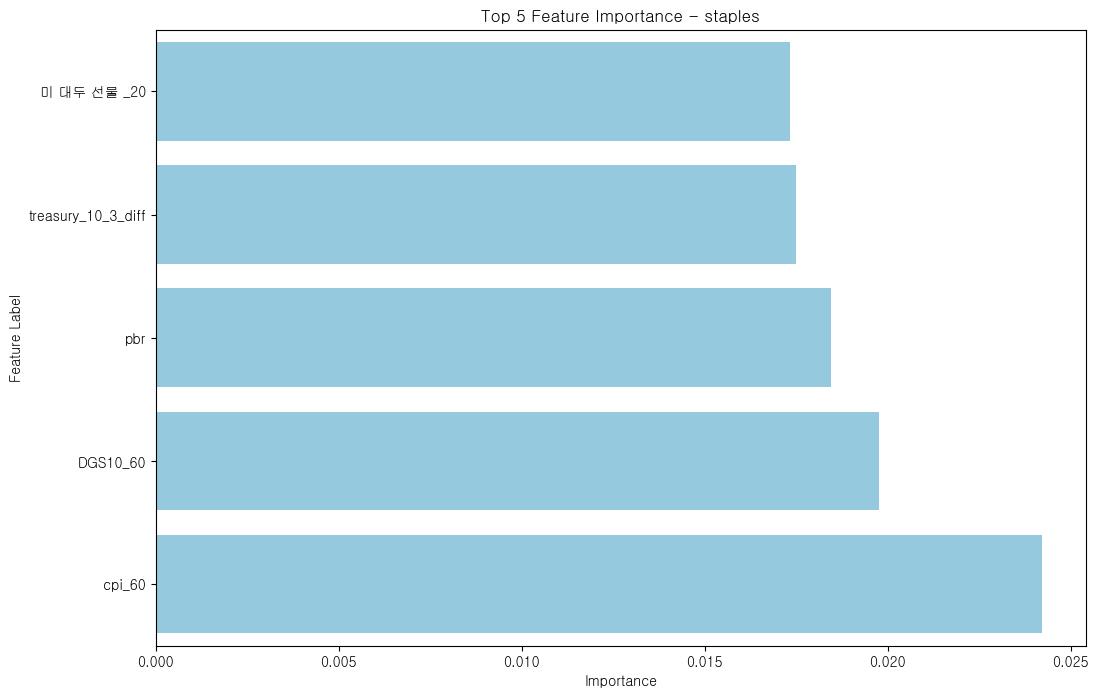

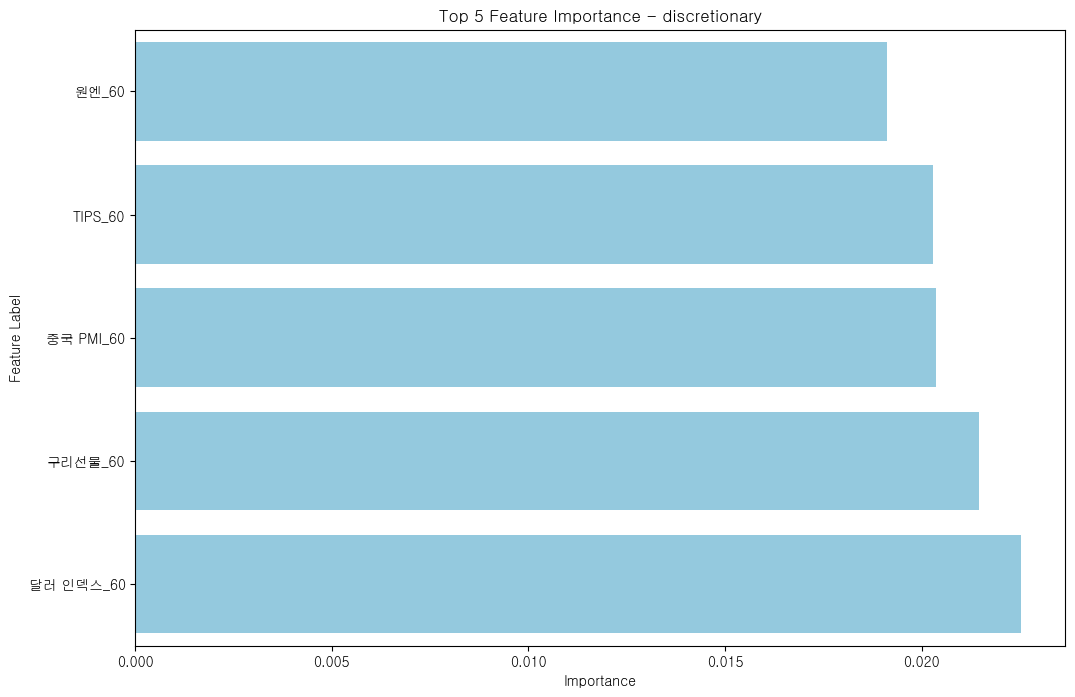

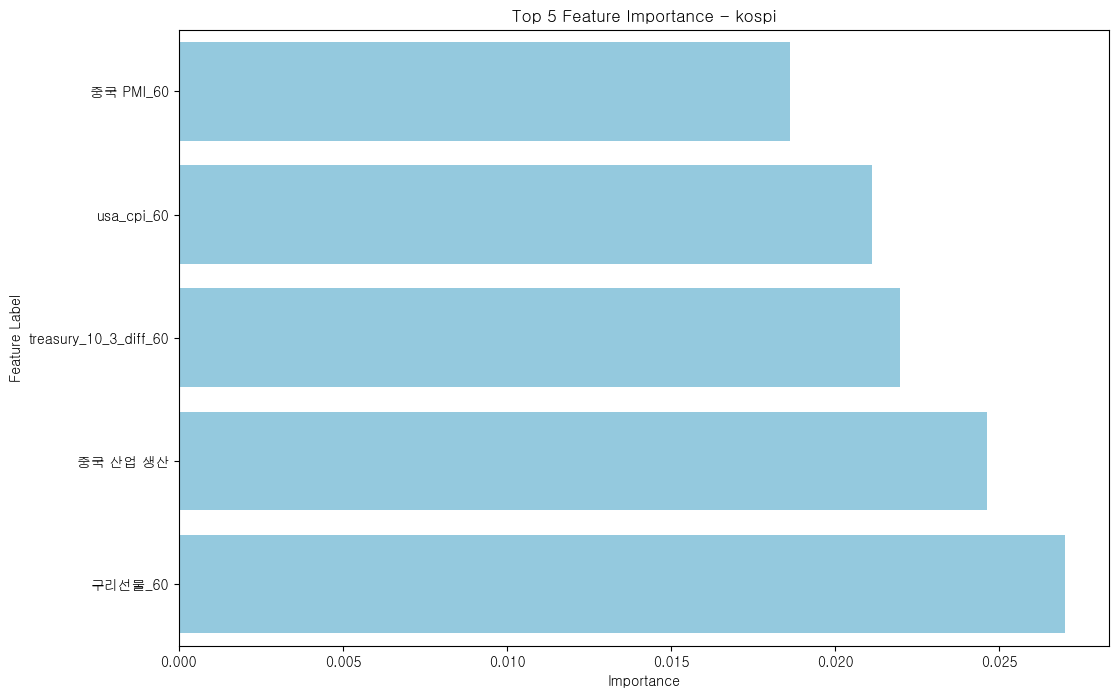

In [11]:
# 각 키워드별 상위 5개 특성의 인덱스와 중요도 출력
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # RandomForestClassifier 초기화 및 학습
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    rfc.fit(X_train, y_train)

    # Feature Importance 계산
    feats = {}
    for feature, importance in zip(range(X_train.shape[1]), rfc.feature_importances_):
        feats[feature] = importance

    # 중요도 순으로 정렬하여 상위 5개와 하위 5개 선택
    sorted_feats = sorted(feats.items(), key=lambda x: x[1], reverse=True)
    top_5_importances = sorted_feats[:5]
    bottom_5_importances = sorted_feats[-5:]
    # 결과 출력
    print(f"{keyword} 키워드의 상위 5개 특성:")
    for feature_index, importance in top_5_importances:
        feature_name = column_names_per_keyword[keyword][feature_index]  # 열 이름 가져오기
        print(f"Feature Name: {feature_name}, Importance: {importance:.4f}")
    print()
    print(f"{keyword} 키워드의 하위 5개 특성:")
    for feature_index, importance in bottom_5_importances:
        feature_name = column_names_per_keyword[keyword][feature_index]  # 열 이름 가져오기
        print(f"Feature Name: {feature_name}, Importance: {importance:.4f}")
    print()

### 이후 이것을 그래프로 변환해서 출력
### 생각보다 자동차지수와 중국 지표 금 구리 이런게 영향을 많이 미치는구마잉!
# 상위 5개 특성의 이름과 중요도 분리하여 그래프 출력
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    best_estimator = best_estimators_per_keyword[keyword]
    best_depth = best_depths_per_keyword[keyword]

    # RandomForestClassifier 초기화 및 학습
    rfc = RandomForestClassifier(n_estimators=best_estimator, 
                                 max_depth=best_depth, 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    rfc.fit(X_train, y_train)

    # Feature Importance 계산
    feats = {}
    for feature, importance in zip(range(X_train.shape[1]), rfc.feature_importances_):
        feats[feature] = importance

    # 중요도 순으로 정렬하여 상위 5개 선택
    sorted_feats = sorted(feats.items(), key=lambda x: x[1], reverse=True)
    top_5_importances = sorted_feats[:5]

    # 상위 5개 특성의 이름과 중요도 분리
    top_5_features = [column_names_per_keyword[keyword][feature_index] for feature_index, _ in top_5_importances]
    top_5_importance_values = [importance for _, importance in top_5_importances]

    # 그래프 출력
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_5_importance_values, y=top_5_features, color='skyblue')
    plt.title(f'Top 5 Feature Importance - {keyword}')
    plt.xlabel('Importance')
    plt.ylabel('Feature Label')
    plt.gca().invert_yaxis()  # y축 라벨 역순으로 표시
    plt.show()


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 디렉토리가 없다면 생성
if not os.path.exists('plk_folder_05'):
    os.makedirs('plk_folder_05')

# 각 키워드별로 최종 모델 학습 및 모델 저장
for keyword, data_split in data_splits.items():
    X_train = data_split['X_train']
    y_train = data_split['y_train']

    # RandomForestClassifier 초기화
    rfc = RandomForestClassifier(n_estimators=best_estimators_per_keyword[keyword], 
                                 max_depth=best_depths_per_keyword[keyword], 
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)

    # 최종 모델 학습
    rfc.fit(X_train, y_train)

    # 모델 저장
    filename = f"plk_folder_05/{keyword}_model.pkl"
    dump(rfc, filename)
    print(f"Model for {keyword} keyword saved as {filename}")

print("\n< AI model: save >")

# 모델 로드
loaded_models = {}

# 각 키워드별로 모델 로드
for keyword in keywords:
    filename = f"plk_folder_05/{keyword}_model.pkl"
    if os.path.exists(filename):
        loaded_models[keyword] = load(filename)
        print(f"Model for {keyword} keyword loaded from {filename}")
    else:
        print(f"Model file for {keyword} keyword does not exist: {filename}")

print("\n< AI model: load >")


Model for auto keyword saved as plk_folder_05/auto_model.pkl
Model for construct keyword saved as plk_folder_05/construct_model.pkl
Model for capital_market keyword saved as plk_folder_05/capital_market_model.pkl
Model for chemicals keyword saved as plk_folder_05/chemicals_model.pkl
Model for equipment keyword saved as plk_folder_05/equipment_model.pkl
Model for transport keyword saved as plk_folder_05/transport_model.pkl
Model for semi keyword saved as plk_folder_05/semi_model.pkl
Model for bank keyword saved as plk_folder_05/bank_model.pkl
Model for steel keyword saved as plk_folder_05/steel_model.pkl
Model for telecom keyword saved as plk_folder_05/telecom_model.pkl
Model for staples keyword saved as plk_folder_05/staples_model.pkl
Model for discretionary keyword saved as plk_folder_05/discretionary_model.pkl
Model for kospi keyword saved as plk_folder_05/kospi_model.pkl

< AI model: save >
Model for auto keyword loaded from plk_folder_05/auto_model.pkl
Model for construct keyword l

auto
S_buy: 0.1065
buy: 0.2130
sell: 0.6804

construct
S_buy: 0.1984
buy: 0.3524
sell: 0.4492

capital_market
S_buy: 0.2022
buy: 0.1596
sell: 0.6381

chemicals
S_buy: 0.3686
buy: 0.1620
sell: 0.4694

equipment
S_buy: 0.5061
buy: 0.1137
sell: 0.3803

transport
S_buy: 0.4002
buy: 0.1018
sell: 0.4980

semi
S_buy: 0.1070
buy: 0.2804
sell: 0.6127

bank
S_buy: 0.2224
buy: 0.2229
sell: 0.5546

steel
S_buy: 0.3531
buy: 0.4351
sell: 0.2117

telecom
S_buy: 0.2000
buy: 0.4500
sell: 0.3500

staples
S_buy: 0.1684
buy: 0.3254
sell: 0.5062

discretionary
S_buy: 0.3684
buy: 0.3158
sell: 0.3158

kospi
S_buy: 0.1903
buy: 0.3774
sell: 0.4323

auto
0.1065   0.2130   0.6804   
construct
0.1984   0.3524   0.4492   
capital_market
0.2022   0.1596   0.6381   
chemicals
0.3686   0.1620   0.4694   
equipment
0.5061   0.1137   0.3803   
transport
0.4002   0.1018   0.4980   
semi
0.1070   0.2804   0.6127   
bank
0.2224   0.2229   0.5546   
steel
0.3531   0.4351   0.2117   
telecom
0.2000   0.4500   0.3500   
stap

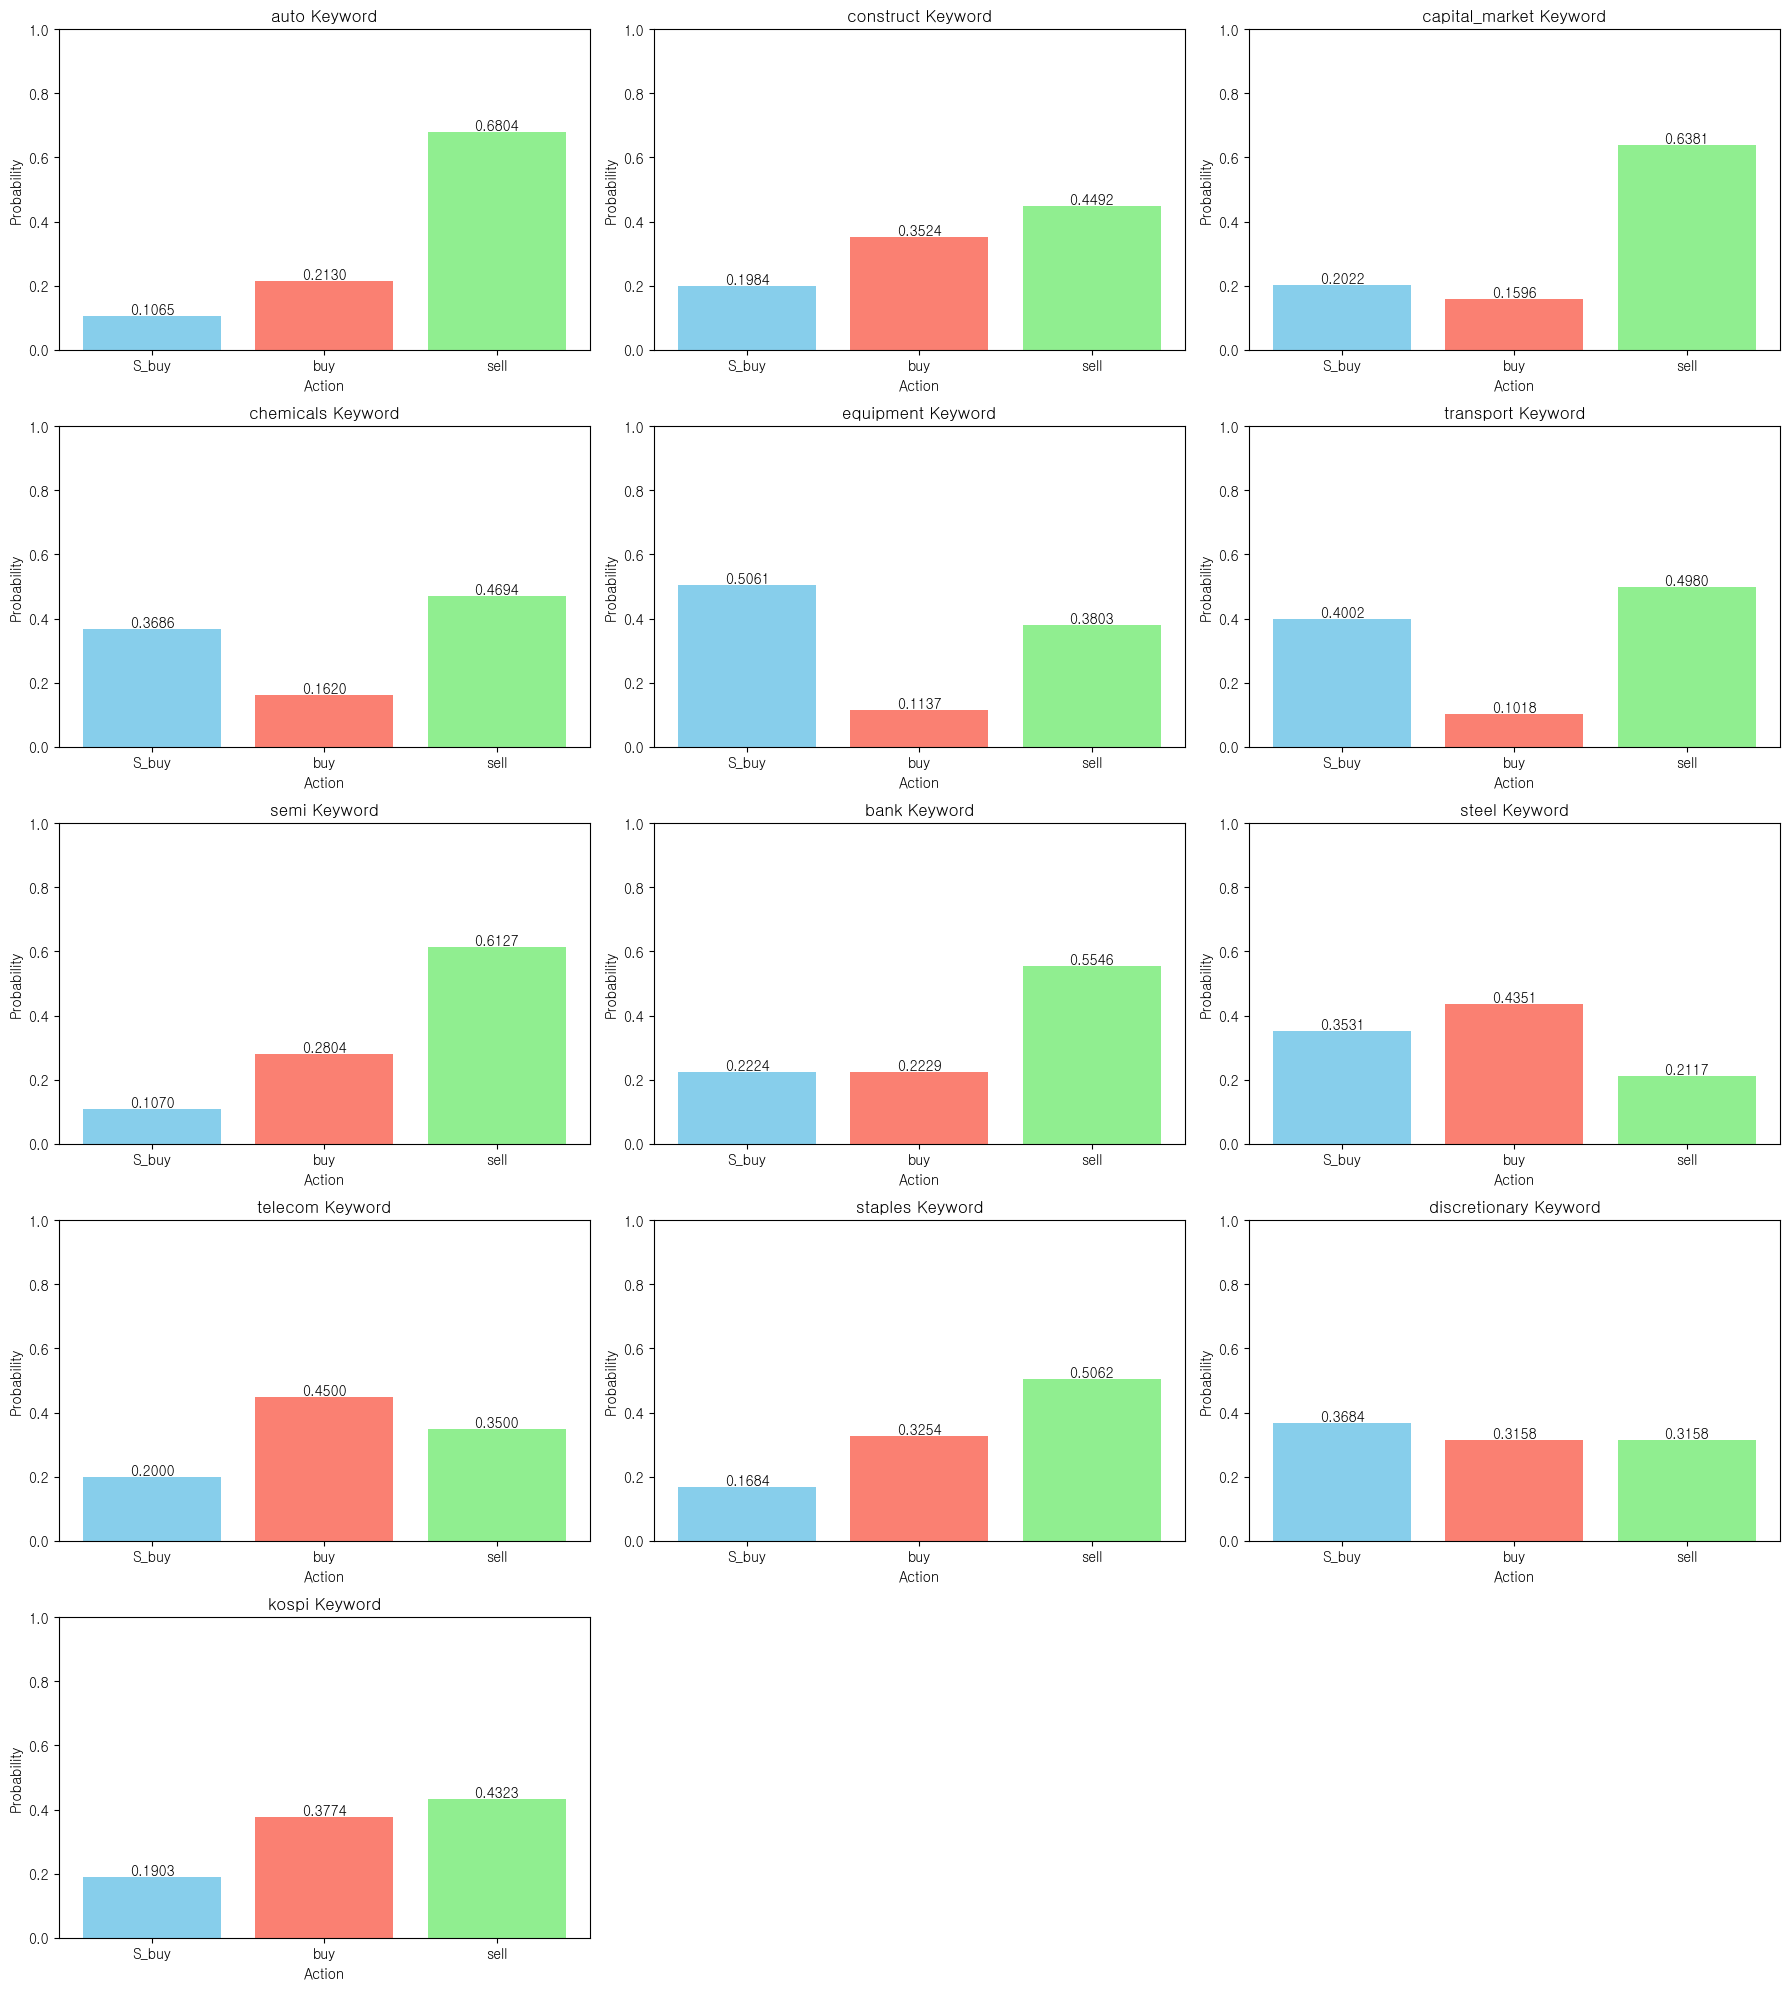

In [19]:
# 각 키워드별로 S_buy, buy, sell의 확률 예측
probabilities = {}
for keyword, model in loaded_models.items():
    # 마지막 행 데이터를 가져와서 예측에 사용
    X_test_last_row_keyword = last_rows[keyword].values.reshape(1, -1)
    # 첫 번째 열(해당 키워드)을 제외하고 예측에 사용
    X_test_last_row_keyword = X_test_last_row_keyword[:, 1:]
    # 각 클래스의 확률 예측
    prob_current = model.predict_proba(X_test_last_row_keyword)
    # 클래스 이름 가져오기
    y_names = model.classes_
    # 결과 저장
    probabilities[keyword] = {'S_buy': prob_current[0][0], 'buy': prob_current[0][1], 'sell': prob_current[0][2]}

# 출력
for keyword, probs in probabilities.items():
    print(keyword)
    for action, prob in probs.items():
        print(f'{action}: {prob:.4f}')
    print()

# 그래프로 출력
num_keywords = len(probabilities)
num_rows = (num_keywords + 2) // 3
num_cols = min(num_keywords, 3)
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for i, (keyword, probs) in enumerate(probabilities.items(), start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.bar(probs.keys(), probs.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(f'{keyword} Keyword')
    plt.xlabel('Action')
    plt.ylabel('Probability')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    print(f'{keyword}')
    for j, prob in enumerate(probs.values()):
        plt.text(j, prob, f'{prob:.4f}', ha='center', va='bottom')
        print(f'{prob:.4f}', end="   ")
    print()
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from joblib import dump, load
from tqdm import tqdm
import os

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows에서의 경우
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Ubuntu에서의 경우
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 설정
CONFIG = {
    'input_file': '0703_total.xlsx',
    'output_folder': 'plk_folder_05_1',
    'keywords': ["auto", "construct", "capital_market", "chemicals", "equipment",
                 "transport", "semi", "bank", "steel",
                 "telecom", "staples", "discretionary", "kospi"],
    'window_sizes': [20, 60],
    'n_estimators_range': range(1, 21),
    'max_depth_range': range(1, 21)
}

def load_data(file_path, sheet_name):
    """엑셀 파일에서 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=0, index_col=0)
        df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
        return df.dropna()
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

def prepare_data(df, keyword):
    """데이터를 학습용으로 준비합니다."""
    y = df[keyword]
    X = df.drop(columns=[keyword])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test, n_estimators, max_depth):
    """모델을 훈련하고 평가합니다."""
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                 max_leaf_nodes=300, n_jobs=-1, random_state=0)
    rfc.fit(X_train, y_train)
    
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')
    y_pred = rfc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    
    return rfc, cv_scores.mean(), accuracy, recall, precision

def find_best_params(X_train, y_train, n_estimators_range, max_depth_range):
    """최적의 하이퍼파라미터를 찾습니다."""
    best_score = 0
    best_params = {}
    
    for n_estimators in tqdm(n_estimators_range):
        for max_depth in max_depth_range:
            rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                         max_leaf_nodes=300, n_jobs=-1, random_state=0)
            score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
            
            if score > best_score:
                best_score = score
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
    
    return best_params

def plot_feature_importance(model, feature_names, keyword):
    """특성 중요도를 시각화합니다."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Top 5 Feature Importance - {keyword}')
    plt.bar(range(5), importances[indices][:5])
    plt.xticks(range(5), [feature_names[i] for i in indices[:5]], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main():
    os.makedirs(CONFIG['output_folder'], exist_ok=True)
    
    for keyword in CONFIG['keywords']:
        print(f"\n처리 중: {keyword}")
        
        df = load_data(CONFIG['input_file'], keyword)
        if df is None:
            continue
        
        X_train, X_test, y_train, y_test = prepare_data(df, keyword)
        
        best_params = find_best_params(X_train, y_train, CONFIG['n_estimators_range'], CONFIG['max_depth_range'])
        print(f"최적 파라미터: {best_params}")
        
        model, cv_score, accuracy, recall, precision = train_and_evaluate_model(
            X_train, X_test, y_train, y_test, best_params['n_estimators'], best_params['max_depth']
        )
        
        print(f"교차 검증 점수: {cv_score:.4f}")
        print(f"정확도: {accuracy:.4f}")
        print(f"재현율: {recall:.4f}")
        print(f"정밀도: {precision:.4f}")
        
        plot_feature_importance(model, df.columns, keyword)
        
        # 모델 저장
        dump(model, f"{CONFIG['output_folder']}/{keyword}_model.pkl")

if __name__ == "__main__":
    main()


처리 중: auto


  5%|▌         | 1/20 [00:10<03:26, 10.87s/it]


KeyboardInterrupt: 

키워드 처리 진행 중:   0%|          | 0/13 [00:00<?, ?it/s]


처리 중: auto


n_estimators 진행 중: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


최적 파라미터: {'n_estimators': 15, 'max_depth': 20}
교차 검증 점수: 0.7901
정확도: 0.8391
재현율: 0.8153
정밀도: 0.8201


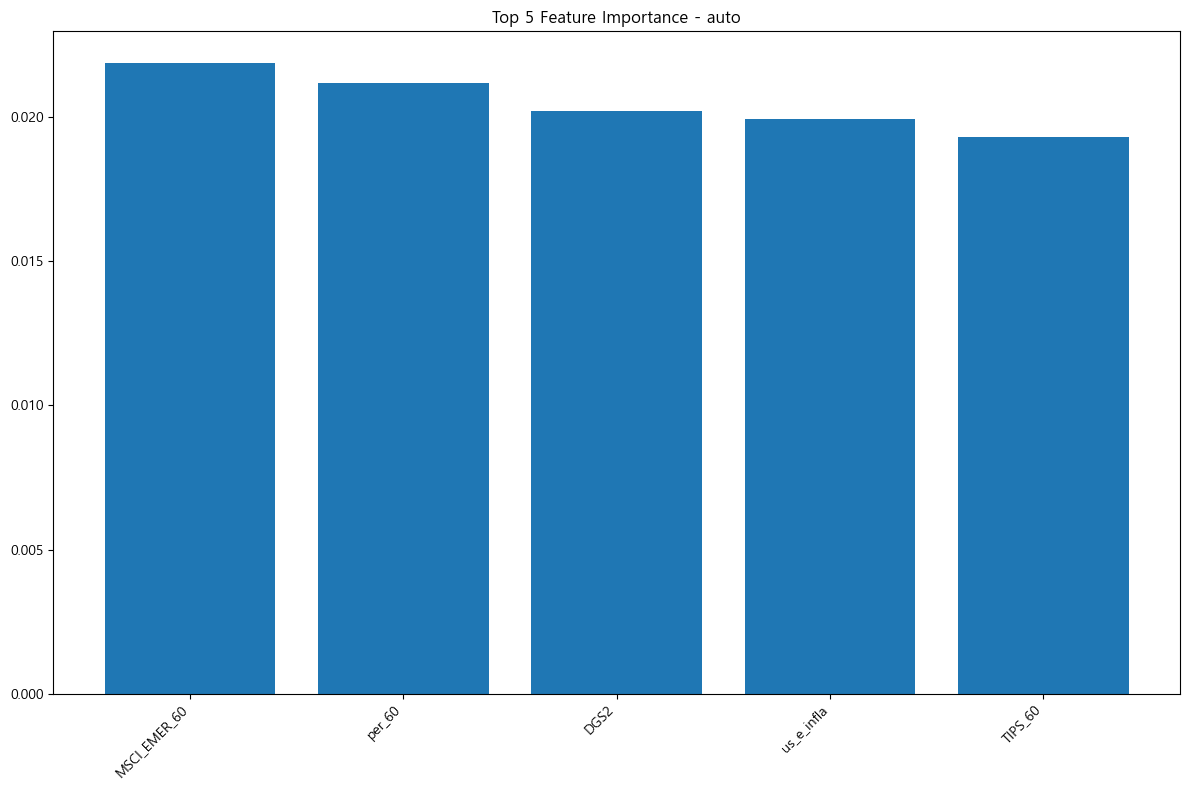

조기 종료: 14 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.7901, 정확도: 0.8391, 재현율: 0.8153, 정밀도: 0.8201

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.7834, 정확도: 0.8375, 재현율: 0.8139, 정밀도: 0.8192

모델 학습 중: CrossValidation


키워드 처리 진행 중:   8%|▊         | 1/13 [00:13<02:42, 13.51s/it]

모델: CrossValidation, 교차 검증 점수: 0.7957, 정확도: 0.8470, 재현율: 0.8229, 정밀도: 0.8268
모델: Basic RandomForest, 교차 검증 점수: 0.7901, 정확도: 0.8391, 재현율: 0.8153, 정밀도: 0.8201
모델: EarlyStopping, 교차 검증 점수: 0.7834, 정확도: 0.8375, 재현율: 0.8139, 정밀도: 0.8192
모델: CrossValidation, 교차 검증 점수: 0.7957, 정확도: 0.8470, 재현율: 0.8229, 정밀도: 0.8268

처리 중: construct


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


최적 파라미터: {'n_estimators': 15, 'max_depth': 20}
교차 검증 점수: 0.8103
정확도: 0.8186
재현율: 0.7661
정밀도: 0.7694


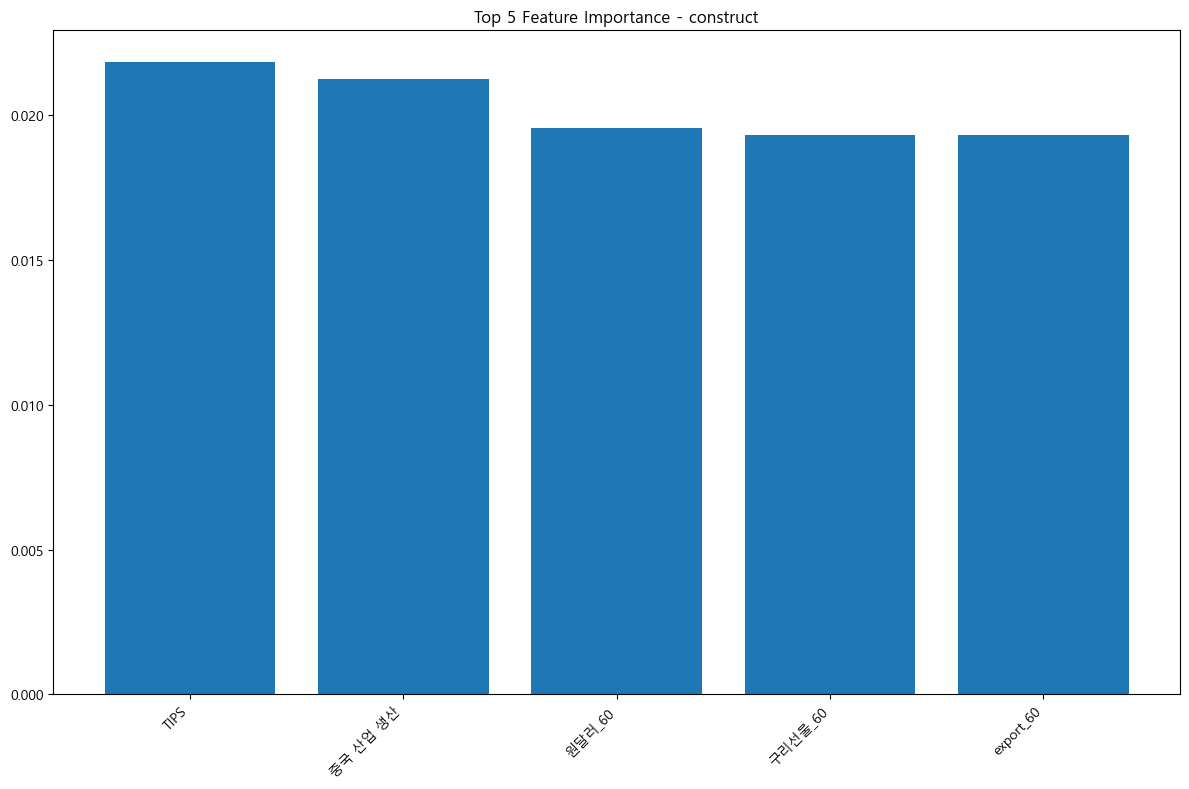

조기 종료: 21 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8103, 정확도: 0.8186, 재현율: 0.7661, 정밀도: 0.7694

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8130, 정확도: 0.8139, 재현율: 0.7618, 정밀도: 0.7652

모델 학습 중: CrossValidation


키워드 처리 진행 중:  15%|█▌        | 2/13 [00:28<02:39, 14.49s/it]

모델: CrossValidation, 교차 검증 점수: 0.8189, 정확도: 0.8186, 재현율: 0.7667, 정밀도: 0.7711
모델: Basic RandomForest, 교차 검증 점수: 0.8103, 정확도: 0.8186, 재현율: 0.7661, 정밀도: 0.7694
모델: EarlyStopping, 교차 검증 점수: 0.8130, 정확도: 0.8139, 재현율: 0.7618, 정밀도: 0.7652
모델: CrossValidation, 교차 검증 점수: 0.8189, 정확도: 0.8186, 재현율: 0.7667, 정밀도: 0.7711

처리 중: capital_market


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
교차 검증 점수: 0.8059
정확도: 0.8486
재현율: 0.8155
정밀도: 0.8200


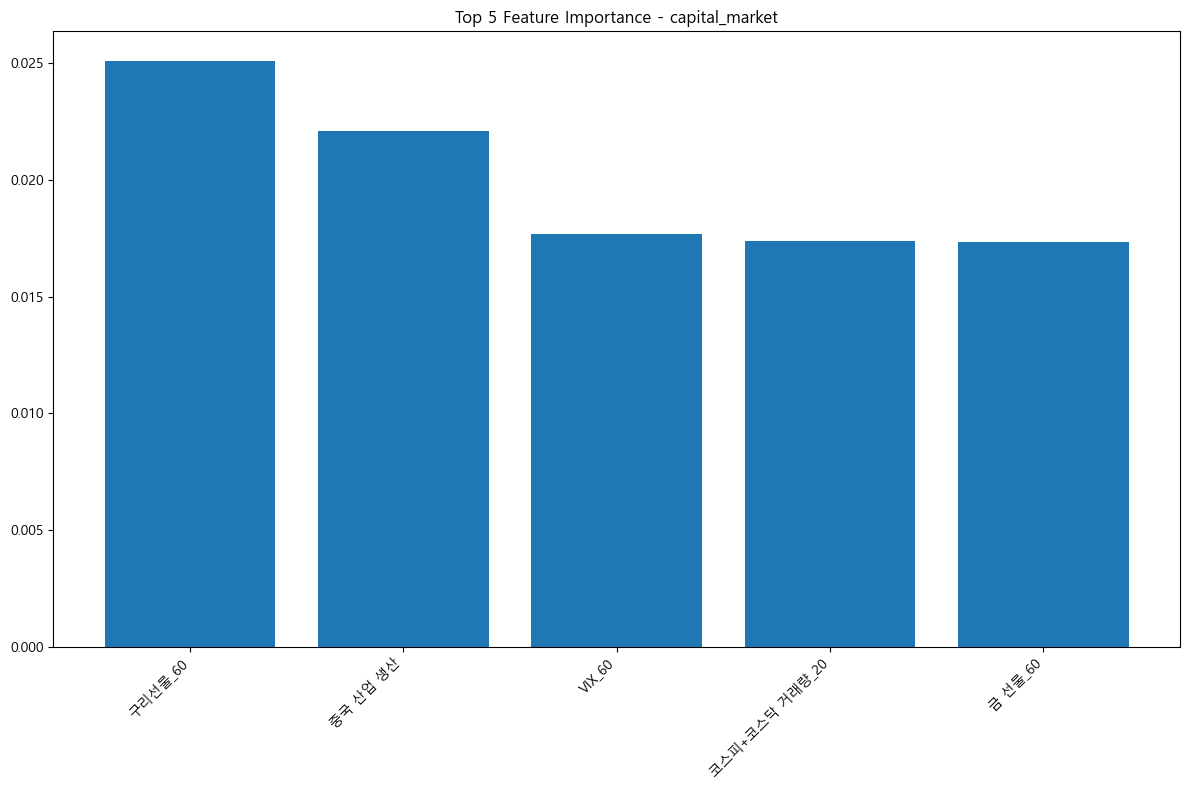

조기 종료: 17 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8059, 정확도: 0.8486, 재현율: 0.8155, 정밀도: 0.8200

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.7988, 정확도: 0.8407, 재현율: 0.8199, 정밀도: 0.8117

모델 학습 중: CrossValidation


키워드 처리 진행 중:  23%|██▎       | 3/13 [00:44<02:29, 14.96s/it]

모델: CrossValidation, 교차 검증 점수: 0.8095, 정확도: 0.8533, 재현율: 0.8237, 정밀도: 0.8204
모델: Basic RandomForest, 교차 검증 점수: 0.8059, 정확도: 0.8486, 재현율: 0.8155, 정밀도: 0.8200
모델: EarlyStopping, 교차 검증 점수: 0.7988, 정확도: 0.8407, 재현율: 0.8199, 정밀도: 0.8117
모델: CrossValidation, 교차 검증 점수: 0.8095, 정확도: 0.8533, 재현율: 0.8237, 정밀도: 0.8204

처리 중: chemicals


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 15}
교차 검증 점수: 0.8166
정확도: 0.8233
재현율: 0.8002
정밀도: 0.8082


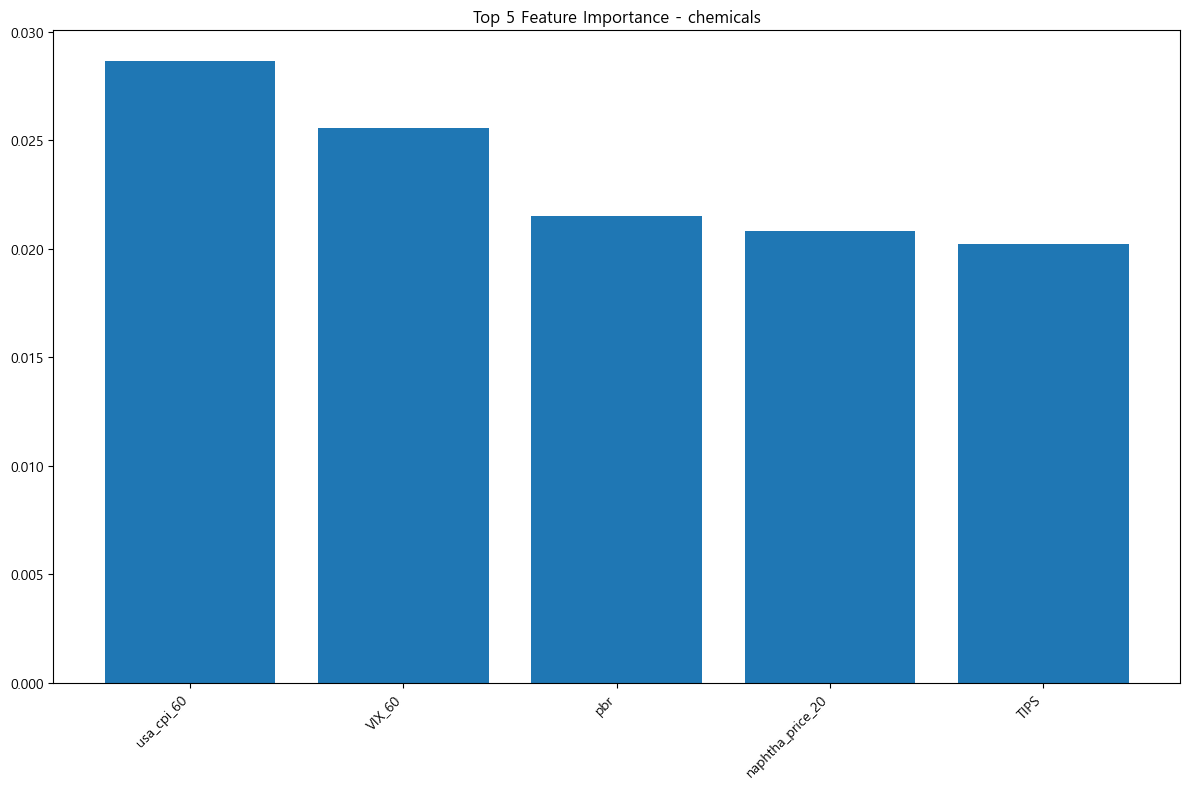

조기 종료: 17 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8166, 정확도: 0.8233, 재현율: 0.8002, 정밀도: 0.8082

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8142, 정확도: 0.8470, 재현율: 0.8321, 정밀도: 0.8354

모델 학습 중: CrossValidation


키워드 처리 진행 중:  31%|███       | 4/13 [00:59<02:15, 15.07s/it]

모델: CrossValidation, 교차 검증 점수: 0.8178, 정확도: 0.8312, 재현율: 0.8035, 정밀도: 0.8197
모델: Basic RandomForest, 교차 검증 점수: 0.8166, 정확도: 0.8233, 재현율: 0.8002, 정밀도: 0.8082
모델: EarlyStopping, 교차 검증 점수: 0.8142, 정확도: 0.8470, 재현율: 0.8321, 정밀도: 0.8354
모델: CrossValidation, 교차 검증 점수: 0.8178, 정확도: 0.8312, 재현율: 0.8035, 정밀도: 0.8197

처리 중: equipment


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


최적 파라미터: {'n_estimators': 15, 'max_depth': 20}
교차 검증 점수: 0.8426
정확도: 0.8312
재현율: 0.7720
정밀도: 0.7785


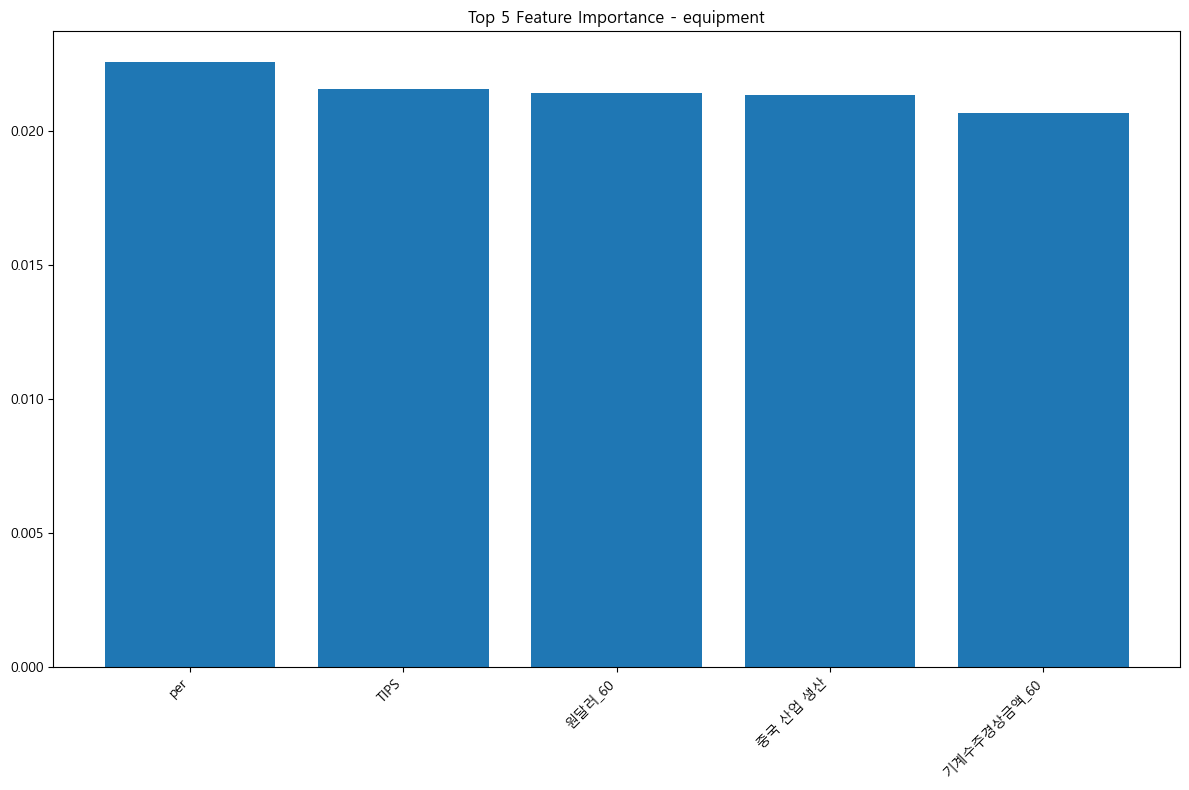

조기 종료: 23 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8426, 정확도: 0.8312, 재현율: 0.7720, 정밀도: 0.7785

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8422, 정확도: 0.8423, 재현율: 0.7873, 정밀도: 0.7963

모델 학습 중: CrossValidation


키워드 처리 진행 중:  38%|███▊      | 5/13 [01:15<02:03, 15.43s/it]

모델: CrossValidation, 교차 검증 점수: 0.8367, 정확도: 0.8454, 재현율: 0.7858, 정밀도: 0.7980
모델: Basic RandomForest, 교차 검증 점수: 0.8426, 정확도: 0.8312, 재현율: 0.7720, 정밀도: 0.7785
모델: EarlyStopping, 교차 검증 점수: 0.8422, 정확도: 0.8423, 재현율: 0.7873, 정밀도: 0.7963
모델: CrossValidation, 교차 검증 점수: 0.8367, 정확도: 0.8454, 재현율: 0.7858, 정밀도: 0.7980

처리 중: transport


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
교차 검증 점수: 0.8213
정확도: 0.8312
재현율: 0.8083
정밀도: 0.8014


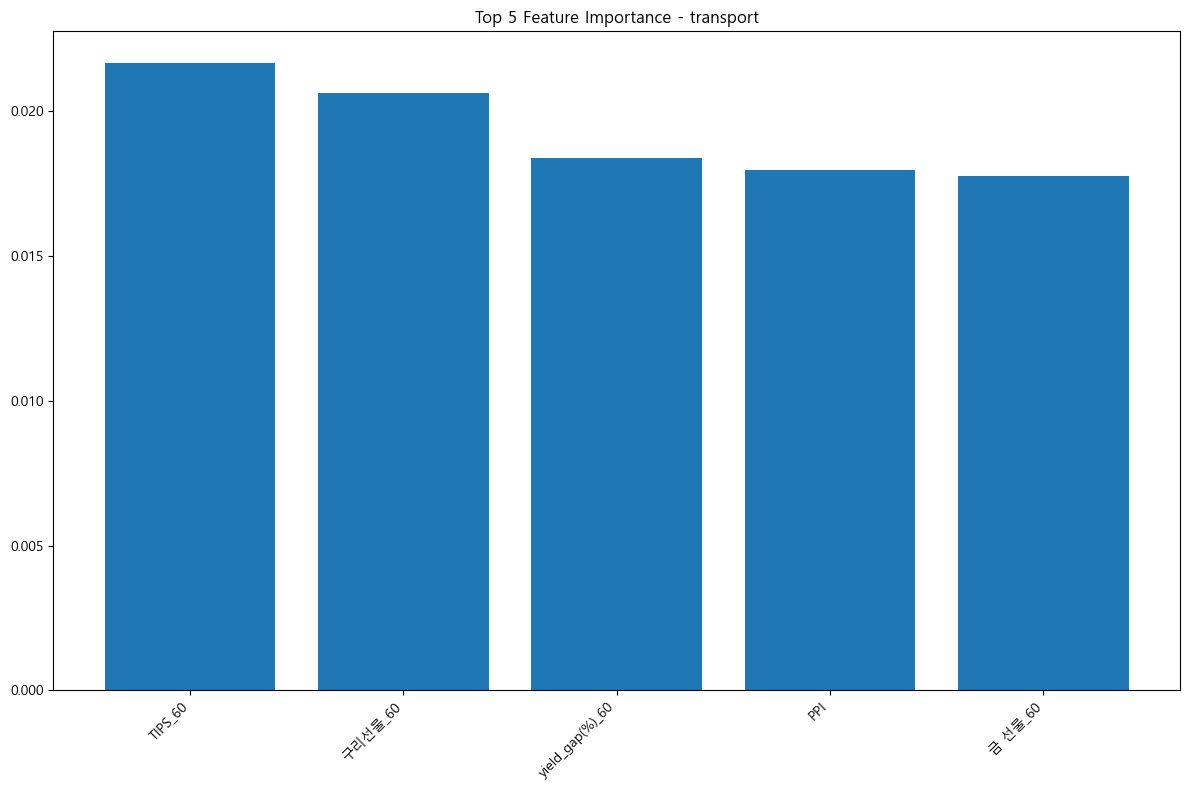

조기 종료: 22 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8213, 정확도: 0.8312, 재현율: 0.8083, 정밀도: 0.8014

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8249, 정확도: 0.8375, 재현율: 0.8091, 정밀도: 0.8070

모델 학습 중: CrossValidation


키워드 처리 진행 중:  46%|████▌     | 6/13 [01:32<01:52, 16.05s/it]

모델: CrossValidation, 교차 검증 점수: 0.8296, 정확도: 0.8375, 재현율: 0.8200, 정밀도: 0.8121
모델: Basic RandomForest, 교차 검증 점수: 0.8213, 정확도: 0.8312, 재현율: 0.8083, 정밀도: 0.8014
모델: EarlyStopping, 교차 검증 점수: 0.8249, 정확도: 0.8375, 재현율: 0.8091, 정밀도: 0.8070
모델: CrossValidation, 교차 검증 점수: 0.8296, 정확도: 0.8375, 재현율: 0.8200, 정밀도: 0.8121

처리 중: semi


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 15}
교차 검증 점수: 0.7878
정확도: 0.7965
재현율: 0.7859
정밀도: 0.7947


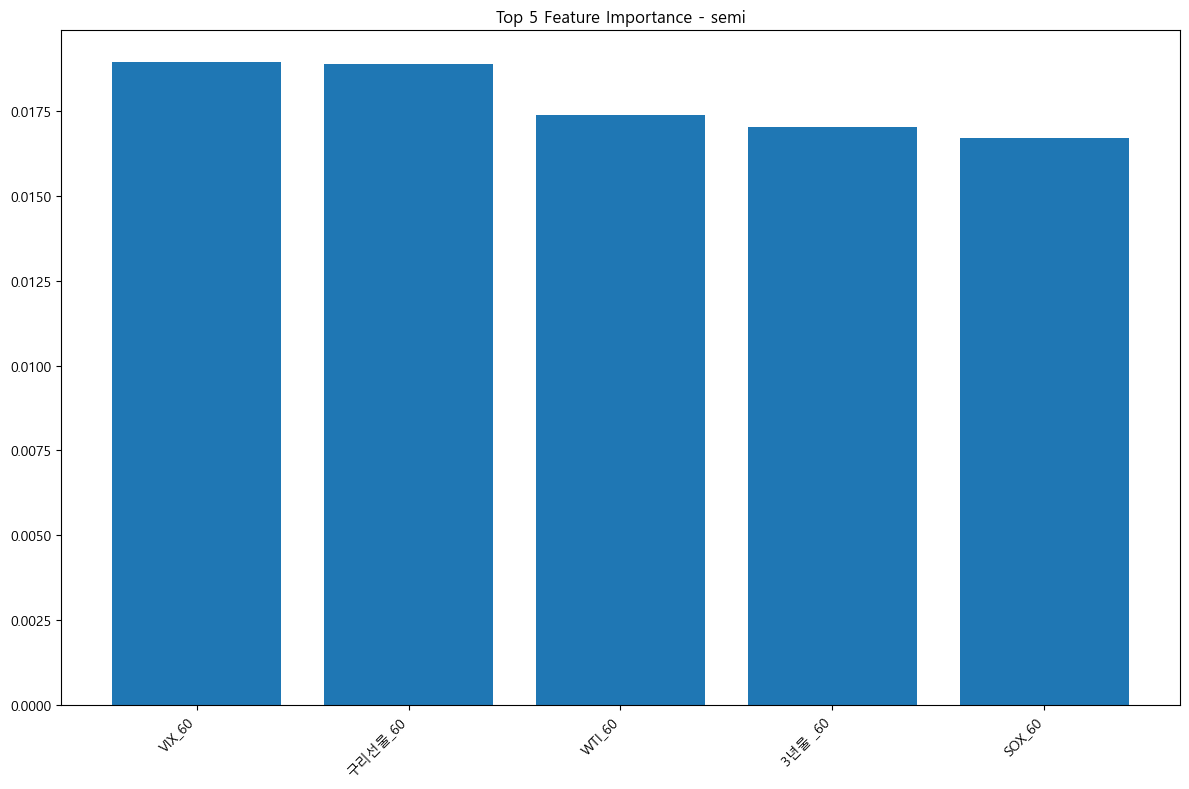

조기 종료: 10 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.7878, 정확도: 0.7965, 재현율: 0.7859, 정밀도: 0.7947

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.7471, 정확도: 0.8028, 재현율: 0.7990, 정밀도: 0.7987

모델 학습 중: CrossValidation


키워드 처리 진행 중:  54%|█████▍    | 7/13 [01:45<01:29, 15.00s/it]

모델: CrossValidation, 교차 검증 점수: 0.7858, 정확도: 0.7965, 재현율: 0.7878, 정밀도: 0.7974
모델: Basic RandomForest, 교차 검증 점수: 0.7878, 정확도: 0.7965, 재현율: 0.7859, 정밀도: 0.7947
모델: EarlyStopping, 교차 검증 점수: 0.7471, 정확도: 0.8028, 재현율: 0.7990, 정밀도: 0.7987
모델: CrossValidation, 교차 검증 점수: 0.7858, 정확도: 0.7965, 재현율: 0.7878, 정밀도: 0.7974

처리 중: bank


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


최적 파라미터: {'n_estimators': 10, 'max_depth': 20}
교차 검증 점수: 0.8166
정확도: 0.8170
재현율: 0.8124
정밀도: 0.7954


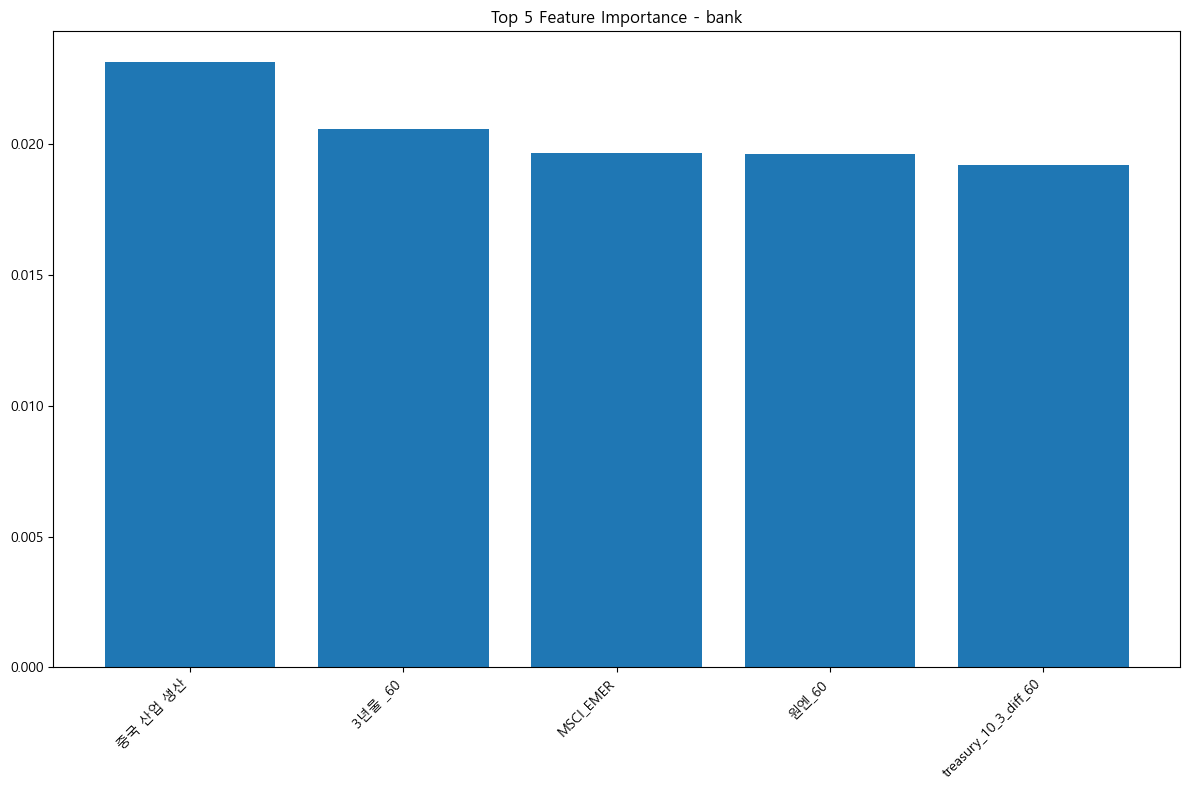

조기 종료: 14 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8166, 정확도: 0.8170, 재현율: 0.8124, 정밀도: 0.7954

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8067, 정확도: 0.8265, 재현율: 0.8183, 정밀도: 0.8026

모델 학습 중: CrossValidation


키워드 처리 진행 중:  62%|██████▏   | 8/13 [01:57<01:09, 13.91s/it]

모델: CrossValidation, 교차 검증 점수: 0.8221, 정확도: 0.8344, 재현율: 0.8232, 정밀도: 0.8104
모델: Basic RandomForest, 교차 검증 점수: 0.8166, 정확도: 0.8170, 재현율: 0.8124, 정밀도: 0.7954
모델: EarlyStopping, 교차 검증 점수: 0.8067, 정확도: 0.8265, 재현율: 0.8183, 정밀도: 0.8026
모델: CrossValidation, 교차 검증 점수: 0.8221, 정확도: 0.8344, 재현율: 0.8232, 정밀도: 0.8104

처리 중: steel


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
교차 검증 점수: 0.8047
정확도: 0.8265
재현율: 0.7926
정밀도: 0.7968


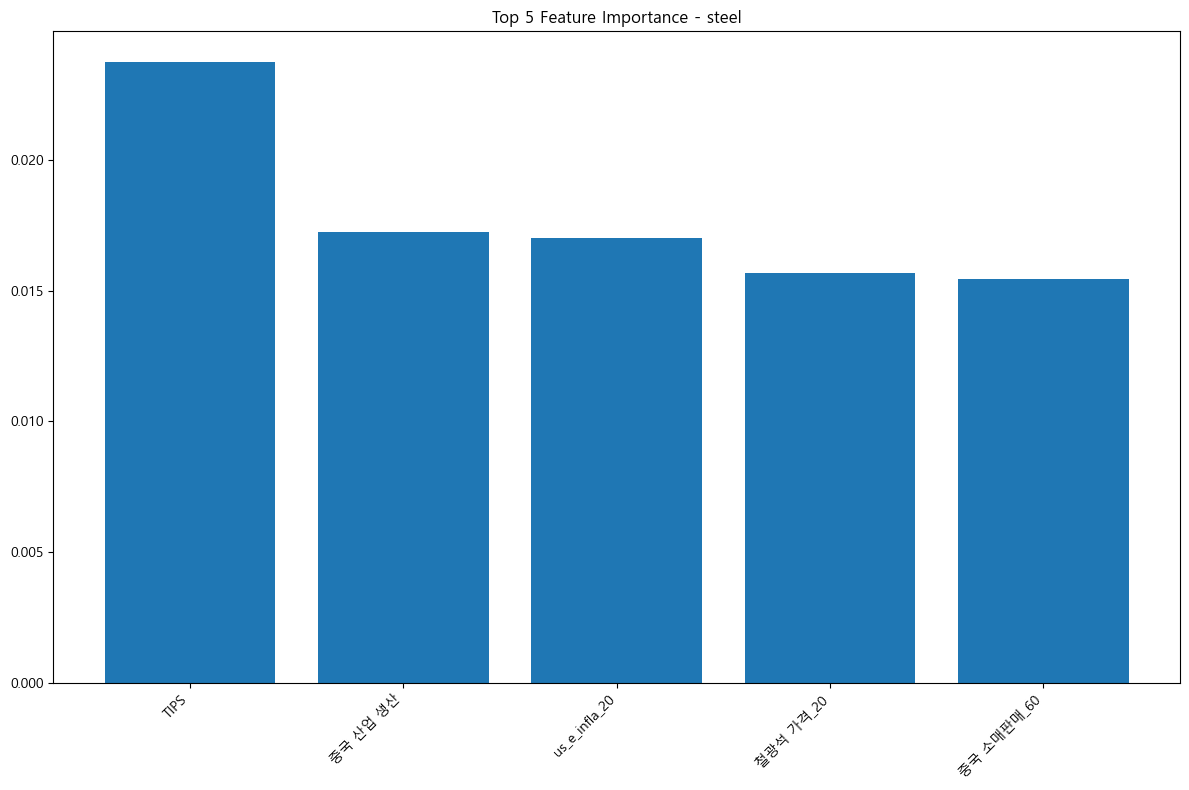

조기 종료: 17 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8047, 정확도: 0.8265, 재현율: 0.7926, 정밀도: 0.7968

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.7968, 정확도: 0.8391, 재현율: 0.8038, 정밀도: 0.8079

모델 학습 중: CrossValidation


키워드 처리 진행 중:  69%|██████▉   | 9/13 [02:12<00:57, 14.35s/it]

모델: CrossValidation, 교차 검증 점수: 0.8095, 정확도: 0.8344, 재현율: 0.7995, 정밀도: 0.8054
모델: Basic RandomForest, 교차 검증 점수: 0.8047, 정확도: 0.8265, 재현율: 0.7926, 정밀도: 0.7968
모델: EarlyStopping, 교차 검증 점수: 0.7968, 정확도: 0.8391, 재현율: 0.8038, 정밀도: 0.8079
모델: CrossValidation, 교차 검증 점수: 0.8095, 정확도: 0.8344, 재현율: 0.7995, 정밀도: 0.8054

처리 중: telecom


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 15}
교차 검증 점수: 0.8422
정확도: 0.8407
재현율: 0.8261
정밀도: 0.8449


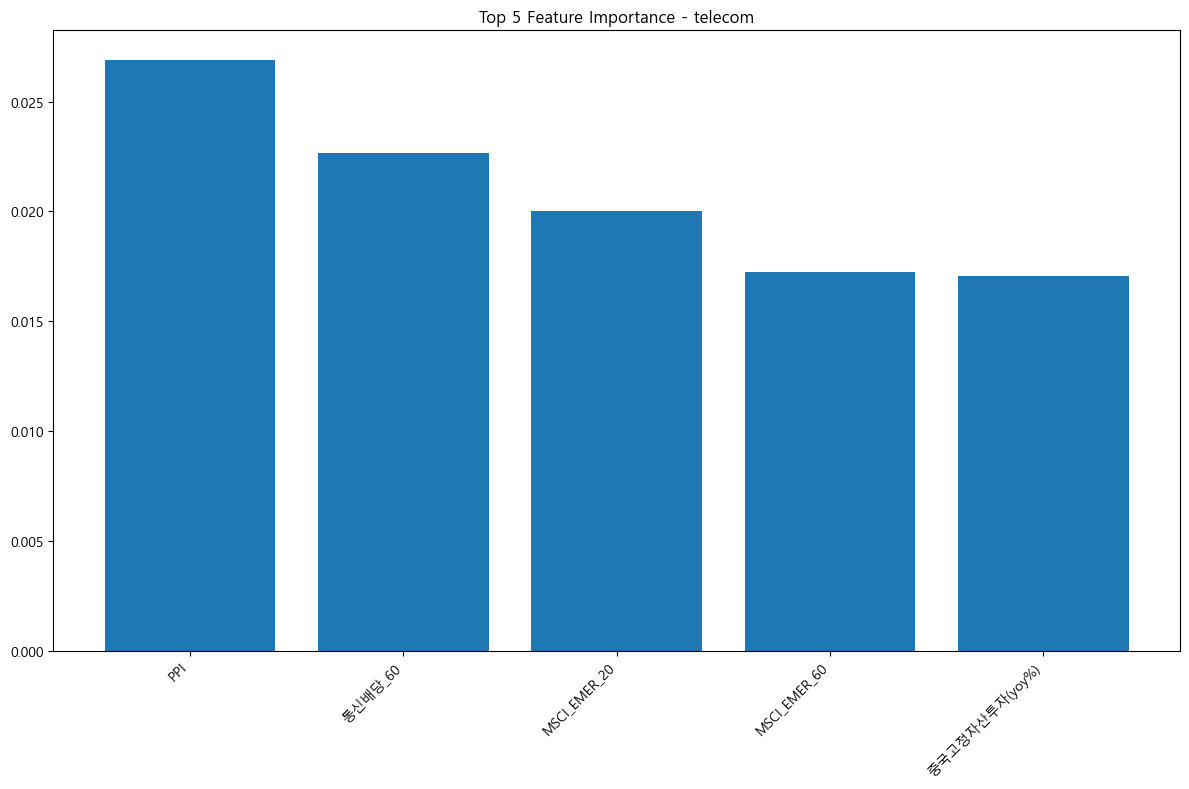

조기 종료: 19 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8422, 정확도: 0.8407, 재현율: 0.8261, 정밀도: 0.8449

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8308, 정확도: 0.8517, 재현율: 0.8294, 정밀도: 0.8520

모델 학습 중: CrossValidation


키워드 처리 진행 중:  77%|███████▋  | 10/13 [02:28<00:44, 14.78s/it]

모델: CrossValidation, 교차 검증 점수: 0.8398, 정확도: 0.8391, 재현율: 0.8133, 정밀도: 0.8413
모델: Basic RandomForest, 교차 검증 점수: 0.8422, 정확도: 0.8407, 재현율: 0.8261, 정밀도: 0.8449
모델: EarlyStopping, 교차 검증 점수: 0.8308, 정확도: 0.8517, 재현율: 0.8294, 정밀도: 0.8520
모델: CrossValidation, 교차 검증 점수: 0.8398, 정확도: 0.8391, 재현율: 0.8133, 정밀도: 0.8413

처리 중: staples


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
교차 검증 점수: 0.8252
정확도: 0.8533
재현율: 0.8117
정밀도: 0.8531


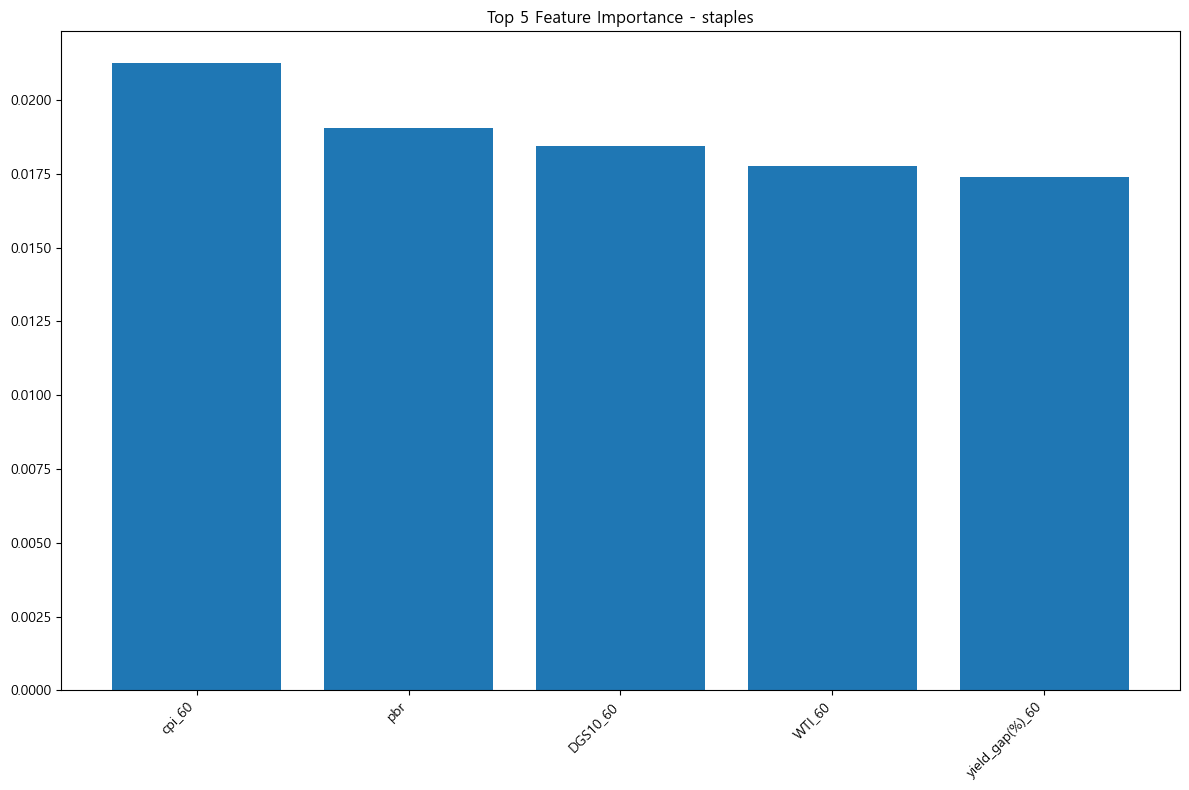

조기 종료: 29 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8252, 정확도: 0.8533, 재현율: 0.8117, 정밀도: 0.8531

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8233, 정확도: 0.8691, 재현율: 0.8333, 정밀도: 0.8671

모델 학습 중: CrossValidation


키워드 처리 진행 중:  85%|████████▍ | 11/13 [02:48<00:33, 16.54s/it]

모델: CrossValidation, 교차 검증 점수: 0.8379, 정확도: 0.8549, 재현율: 0.8175, 정밀도: 0.8553
모델: Basic RandomForest, 교차 검증 점수: 0.8252, 정확도: 0.8533, 재현율: 0.8117, 정밀도: 0.8531
모델: EarlyStopping, 교차 검증 점수: 0.8233, 정확도: 0.8691, 재현율: 0.8333, 정밀도: 0.8671
모델: CrossValidation, 교차 검증 점수: 0.8379, 정확도: 0.8549, 재현율: 0.8175, 정밀도: 0.8553

처리 중: discretionary


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
교차 검증 점수: 0.8249
정확도: 0.8170
재현율: 0.8029
정밀도: 0.8066


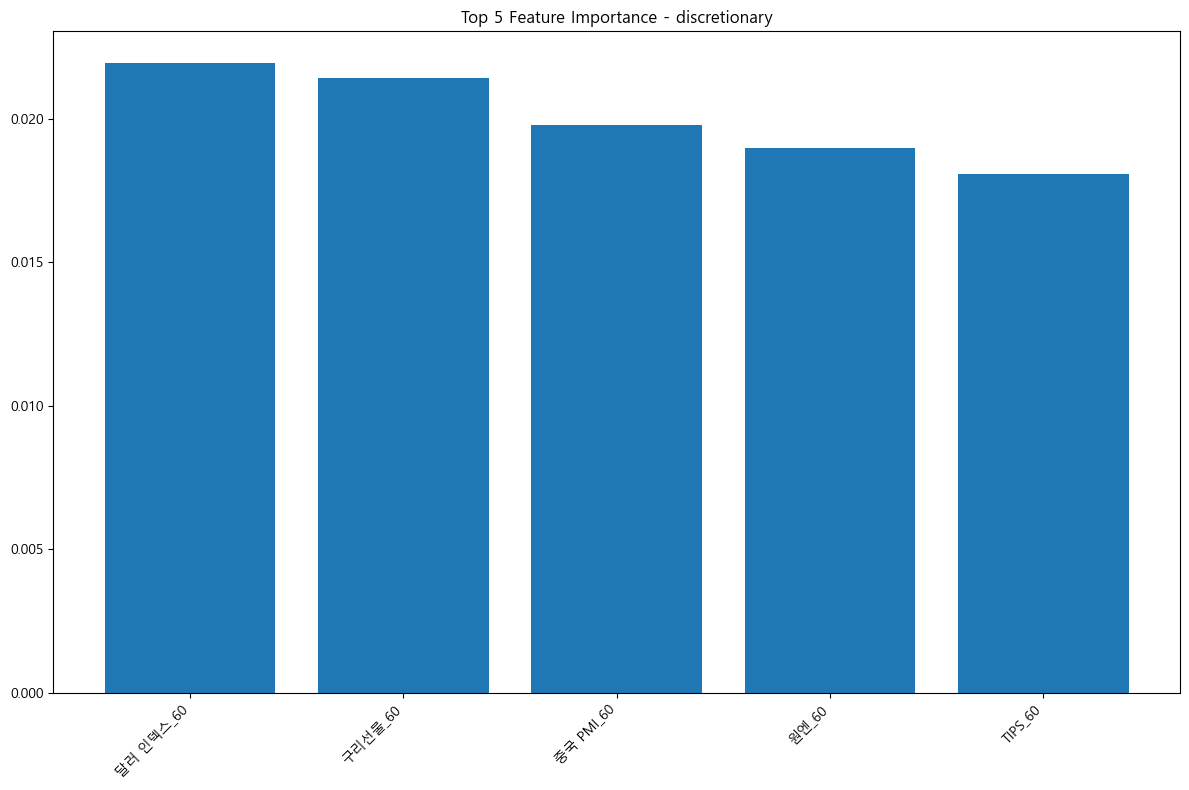

조기 종료: 14 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8249, 정확도: 0.8170, 재현율: 0.8029, 정밀도: 0.8066

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8158, 정확도: 0.8233, 재현율: 0.8163, 정밀도: 0.8098

모델 학습 중: CrossValidation


키워드 처리 진행 중:  92%|█████████▏| 12/13 [03:03<00:15, 15.92s/it]

모델: CrossValidation, 교차 검증 점수: 0.8241, 정확도: 0.8218, 재현율: 0.8110, 정밀도: 0.8132
모델: Basic RandomForest, 교차 검증 점수: 0.8249, 정확도: 0.8170, 재현율: 0.8029, 정밀도: 0.8066
모델: EarlyStopping, 교차 검증 점수: 0.8158, 정확도: 0.8233, 재현율: 0.8163, 정밀도: 0.8098
모델: CrossValidation, 교차 검증 점수: 0.8241, 정확도: 0.8218, 재현율: 0.8110, 정밀도: 0.8132

처리 중: kospi


n_estimators 진행 중: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
교차 검증 점수: 0.8509
정확도: 0.8628
재현율: 0.8468
정밀도: 0.8595


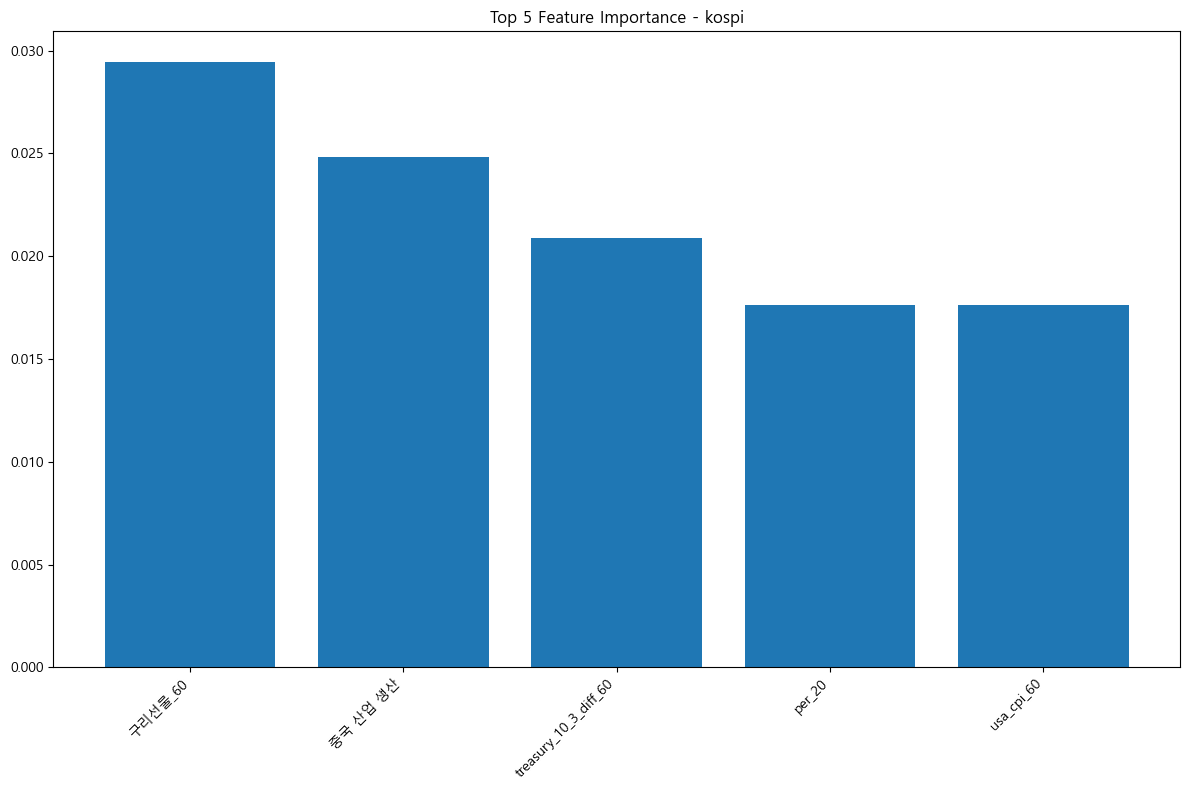

조기 종료: 12 에포크에서 종료



모델 학습 중: Basic RandomForest


모델: Basic RandomForest, 교차 검증 점수: 0.8509, 정확도: 0.8628, 재현율: 0.8468, 정밀도: 0.8595

모델 학습 중: EarlyStopping


모델: EarlyStopping, 교차 검증 점수: 0.8391, 정확도: 0.8502, 재현율: 0.8258, 정밀도: 0.8482

모델 학습 중: CrossValidation


키워드 처리 진행 중: 100%|██████████| 13/13 [03:17<00:00, 15.16s/it]

모델: CrossValidation, 교차 검증 점수: 0.8442, 정확도: 0.8486, 재현율: 0.8200, 정밀도: 0.8354
모델: Basic RandomForest, 교차 검증 점수: 0.8509, 정확도: 0.8628, 재현율: 0.8468, 정밀도: 0.8595
모델: EarlyStopping, 교차 검증 점수: 0.8391, 정확도: 0.8502, 재현율: 0.8258, 정밀도: 0.8482
모델: CrossValidation, 교차 검증 점수: 0.8442, 정확도: 0.8486, 재현율: 0.8200, 정밀도: 0.8354


In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from joblib import dump, load
from tqdm import tqdm
import os

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows에서의 경우
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Ubuntu에서의 경우
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 설정
CONFIG = {
    'input_file': '0703_total.xlsx',
    'output_folder': 'plk_folder_05_1',
    'keywords': ["auto", "construct", "capital_market", "chemicals", "equipment",
                 "transport", "semi", "bank", "steel",
                 "telecom", "staples", "discretionary", "kospi"],
    'window_sizes': [20, 60],
    'n_estimators_range': range(5, 21, 5),  # 하이퍼파라미터 탐색 범위 축소
    'max_depth_range': range(5, 21, 5)  # 하이퍼파라미터 탐색 범위 축소
}

def load_data(file_path, sheet_name):
    """엑셀 파일에서 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=0, index_col=0)
        df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
        return df.dropna()
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

def prepare_data(df, keyword):
    """데이터를 학습용으로 준비합니다."""
    y = df[keyword]
    X = df.drop(columns=[keyword])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test, n_estimators, max_depth):
    """모델을 훈련하고 평가합니다."""
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                 max_leaf_nodes=300, n_jobs=-1, random_state=0)
    rfc.fit(X_train, y_train)
    
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')  # 교차 검증 폴드 수 줄이기
    y_pred = rfc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    
    return rfc, cv_scores.mean(), accuracy, recall, precision

def find_best_params(X_train, y_train, n_estimators_range, max_depth_range):
    """최적의 하이퍼파라미터를 찾습니다."""
    best_score = 0
    best_params = {}
    
    for n_estimators in tqdm(n_estimators_range, desc="n_estimators 진행 중"):
        for max_depth in max_depth_range:
            rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                         max_leaf_nodes=300, n_jobs=-1, random_state=0)
            score = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy').mean()  # 교차 검증 폴드 수 줄이기
            
            if score > best_score:
                best_score = score
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
    
    return best_params

def plot_feature_importance(model, feature_names, keyword):
    """특성 중요도를 시각화합니다."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Top 5 Feature Importance - {keyword}')
    plt.bar(range(5), importances[indices][:5])
    plt.xticks(range(5), [feature_names[i] for i in indices[:5]], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def early_stopping_model(X_train, y_train, X_test, y_test, patience=5):
    """조기 종료를 사용한 모델 훈련."""
    best_score = 0
    best_model = None
    no_improvement = 0
    
    model = RandomForestClassifier(random_state=0)
    for i in range(1, 101):
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)
        score = accuracy_score(y_test, model.predict(X_test))
        
        if score > best_score:
            best_score = score
            best_model = clone(model)
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print(f"조기 종료: {i} 에포크에서 종료")
            break
    
    return best_model

def compare_models(X_train, X_test, y_train, y_test, best_params):
    models = {
        'Basic RandomForest': RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                                                     max_depth=best_params['max_depth'], 
                                                     max_leaf_nodes=300, n_jobs=-1, random_state=0),
        'EarlyStopping': early_stopping_model(X_train, y_train, X_test, y_test),
        'CrossValidation': VotingClassifier(estimators=[
            ('rfc1', RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=0)),
            ('rfc2', RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=1)),
            ('rfc3', RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=2))
        ], voting='soft')
    }

    results = []

    for model_name, model in tqdm(models.items(), desc="모델 비교 진행 중"):
        print(f"\n모델 학습 중: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
        precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 교차 검증 폴드 수 줄이기
        cv_score = cv_scores.mean()

        print(f"모델: {model_name}, 교차 검증 점수: {cv_score:.4f}, 정확도: {accuracy:.4f}, 재현율: {recall:.4f}, 정밀도: {precision:.4f}")
        results.append((model_name, cv_score, accuracy, recall, precision))

    return results

def main():
    os.makedirs(CONFIG['output_folder'], exist_ok=True)
    
    for keyword in tqdm(CONFIG['keywords'], desc="키워드 처리 진행 중"):
        print(f"\n처리 중: {keyword}")
        
        df = load_data(CONFIG['input_file'], keyword)
        if df is None:
            continue
        
        # 데이터 샘플링 (데이터가 많을 경우 일부만 사용)
        df_sampled = df.sample(frac=0.1, random_state=0) if len(df) > 10000 else df
        
        X_train, X_test, y_train, y_test = prepare_data(df_sampled, keyword)
        
        best_params = find_best_params(X_train, y_train, CONFIG['n_estimators_range'], CONFIG['max_depth_range'])
        print(f"최적 파라미터: {best_params}")
        
        model, cv_score, accuracy, recall, precision = train_and_evaluate_model(
            X_train, X_test, y_train, y_test, best_params['n_estimators'], best_params['max_depth']
        )
        
        print(f"교차 검증 점수: {cv_score:.4f}")
        print(f"정확도: {accuracy:.4f}")
        print(f"재현율: {recall:.4f}")
        print(f"정밀도: {precision:.4f}")
        
        plot_feature_importance(model, df.columns, keyword)
        
        # 모델 저장
        dump(model, f"{CONFIG['output_folder']}/{keyword}_model.pkl")
        
        # 추가 모델 평가
        results = compare_models(X_train, X_test, y_train, y_test, best_params)
        for result in results:
            print(f"모델: {result[0]}, 교차 검증 점수: {result[1]:.4f}, 정확도: {result[2]:.4f}, 재현율: {result[3]:.4f}, 정밀도: {result[4]:.4f}")

if __name__ == "__main__":
    main()


키워드 처리 진행 중:   0%|          | 0/13 [00:00<?, ?it/s]


처리 중: auto


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


최적 파라미터: {'n_estimators': 15, 'max_depth': 20}
조기 종료: 14 에포크에서 종료
조기 종료 모델 - auto: 정확도: 0.8375, 재현율: 0.8139, 정밀도: 0.8192


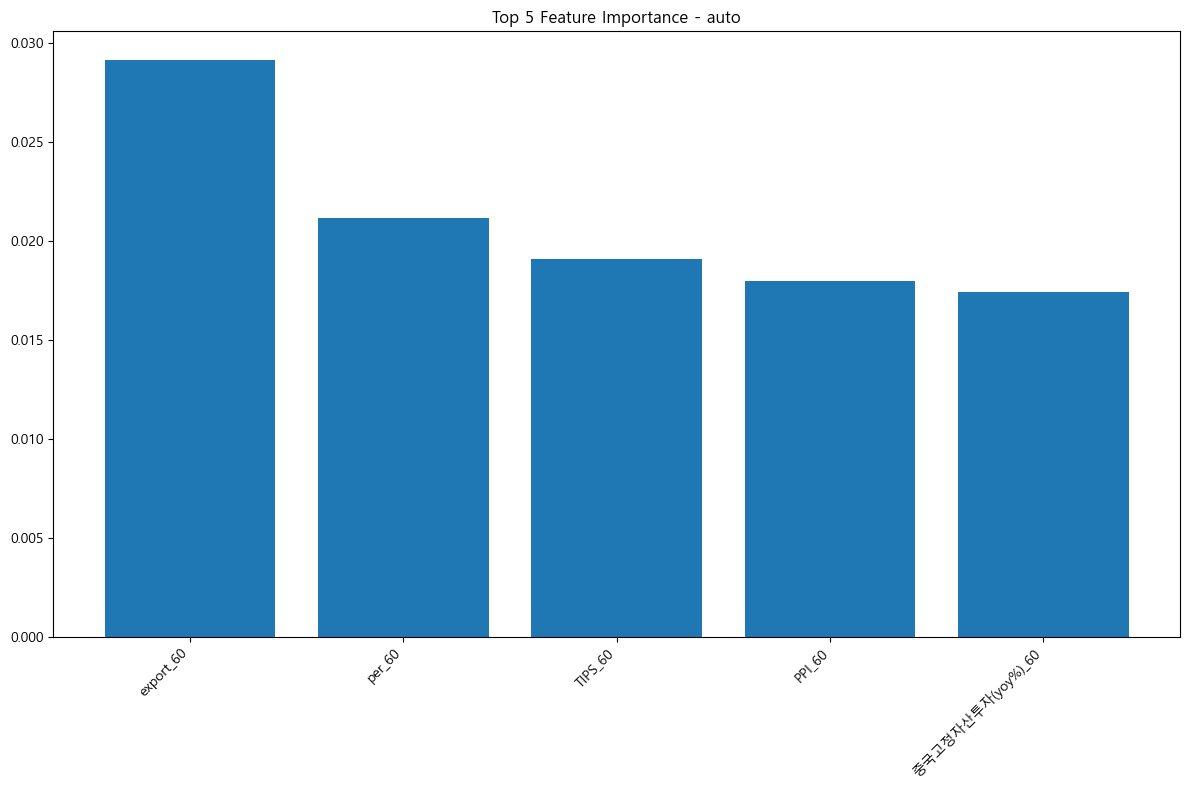

키워드 처리 진행 중:   8%|▊         | 1/13 [00:08<01:47,  8.97s/it]


처리 중: construct


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


최적 파라미터: {'n_estimators': 15, 'max_depth': 20}
조기 종료: 21 에포크에서 종료
조기 종료 모델 - construct: 정확도: 0.8139, 재현율: 0.7618, 정밀도: 0.7652


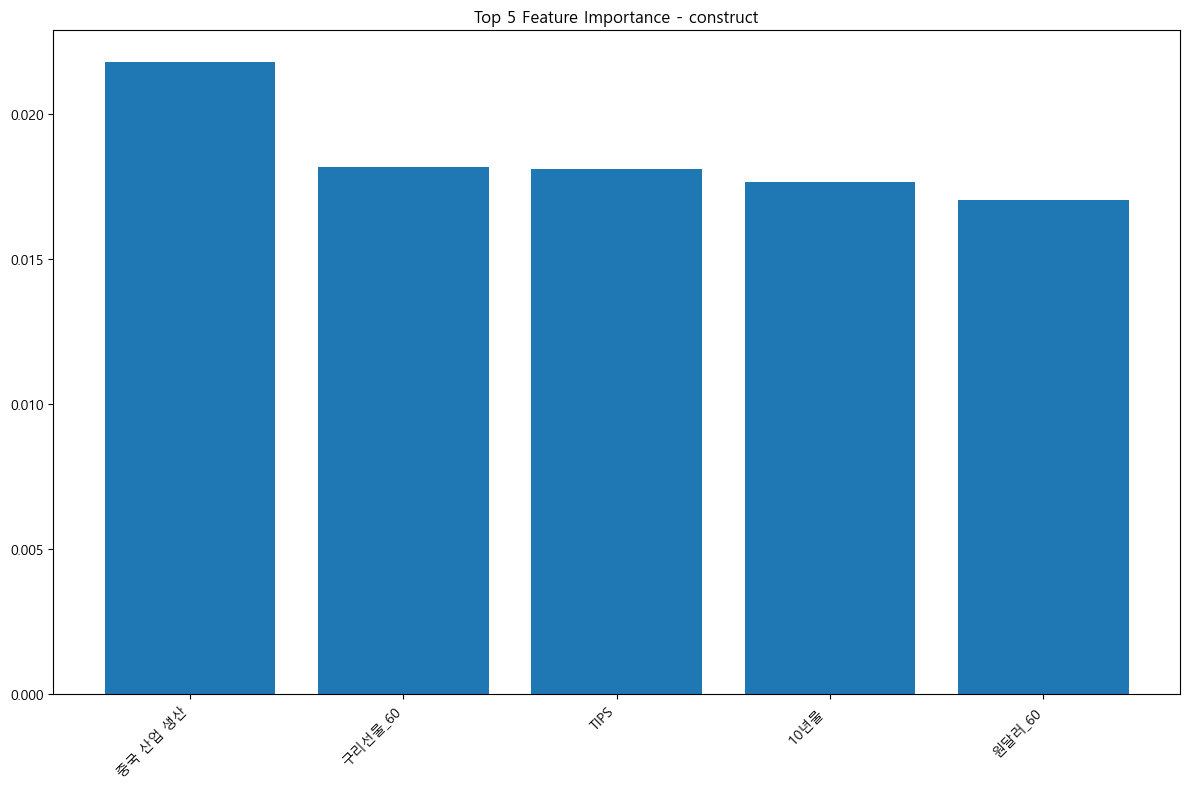

키워드 처리 진행 중:  15%|█▌        | 2/13 [00:18<01:44,  9.54s/it]


처리 중: capital_market


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
조기 종료: 17 에포크에서 종료
조기 종료 모델 - capital_market: 정확도: 0.8407, 재현율: 0.8199, 정밀도: 0.8117


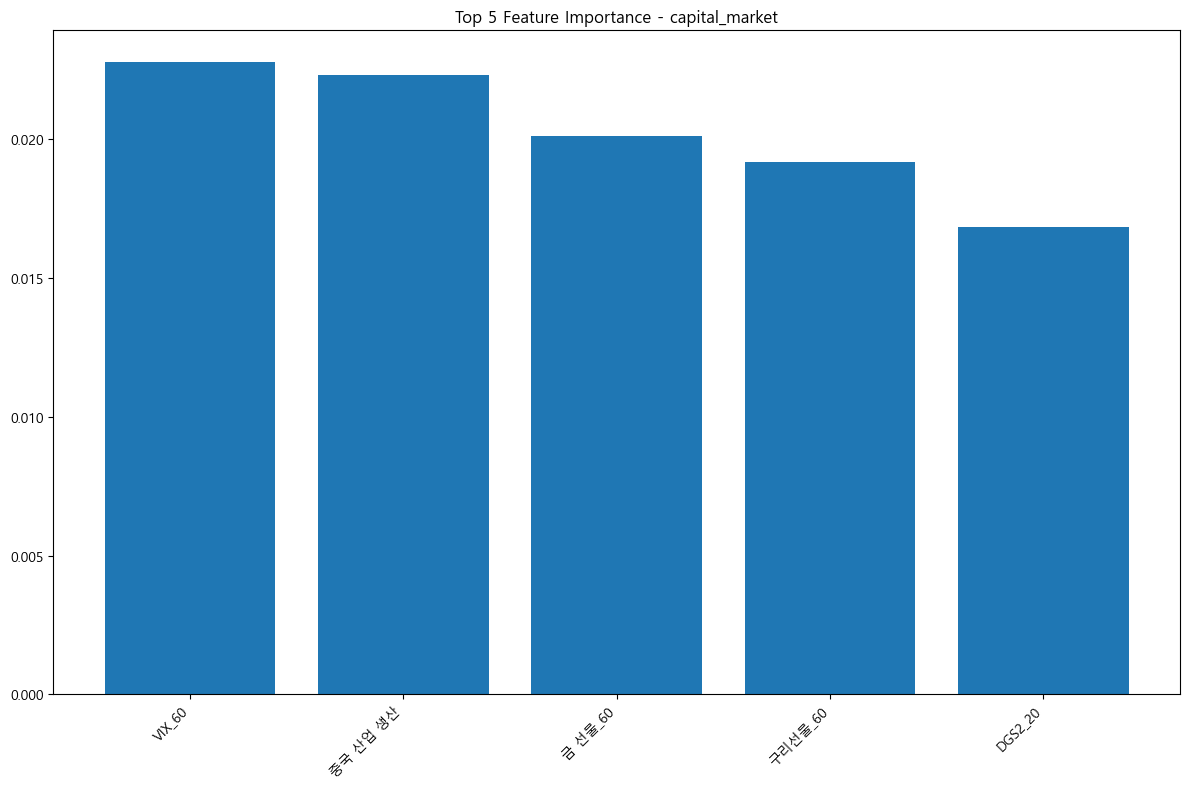

키워드 처리 진행 중:  23%|██▎       | 3/13 [00:28<01:34,  9.44s/it]


처리 중: chemicals


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 15}
조기 종료: 17 에포크에서 종료
조기 종료 모델 - chemicals: 정확도: 0.8470, 재현율: 0.8321, 정밀도: 0.8354


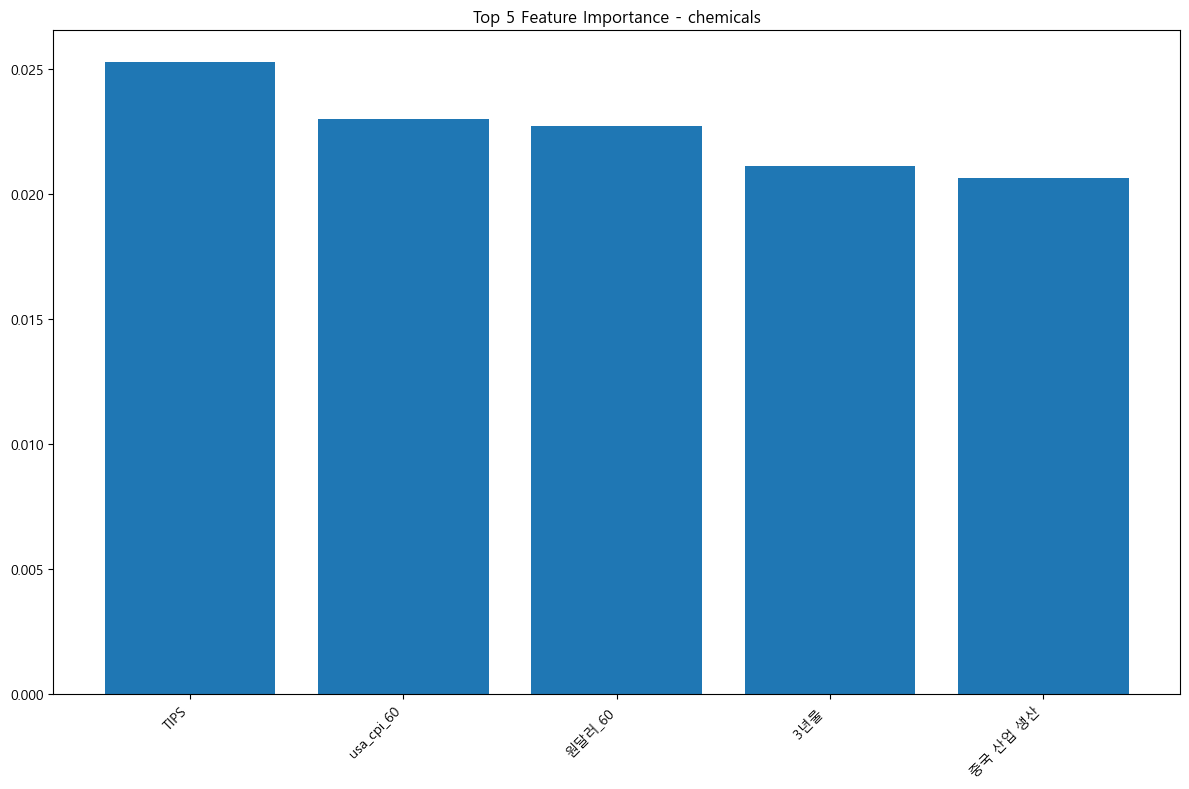

키워드 처리 진행 중:  31%|███       | 4/13 [00:37<01:24,  9.35s/it]


처리 중: equipment


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


최적 파라미터: {'n_estimators': 15, 'max_depth': 20}
조기 종료: 23 에포크에서 종료
조기 종료 모델 - equipment: 정확도: 0.8423, 재현율: 0.7873, 정밀도: 0.7963


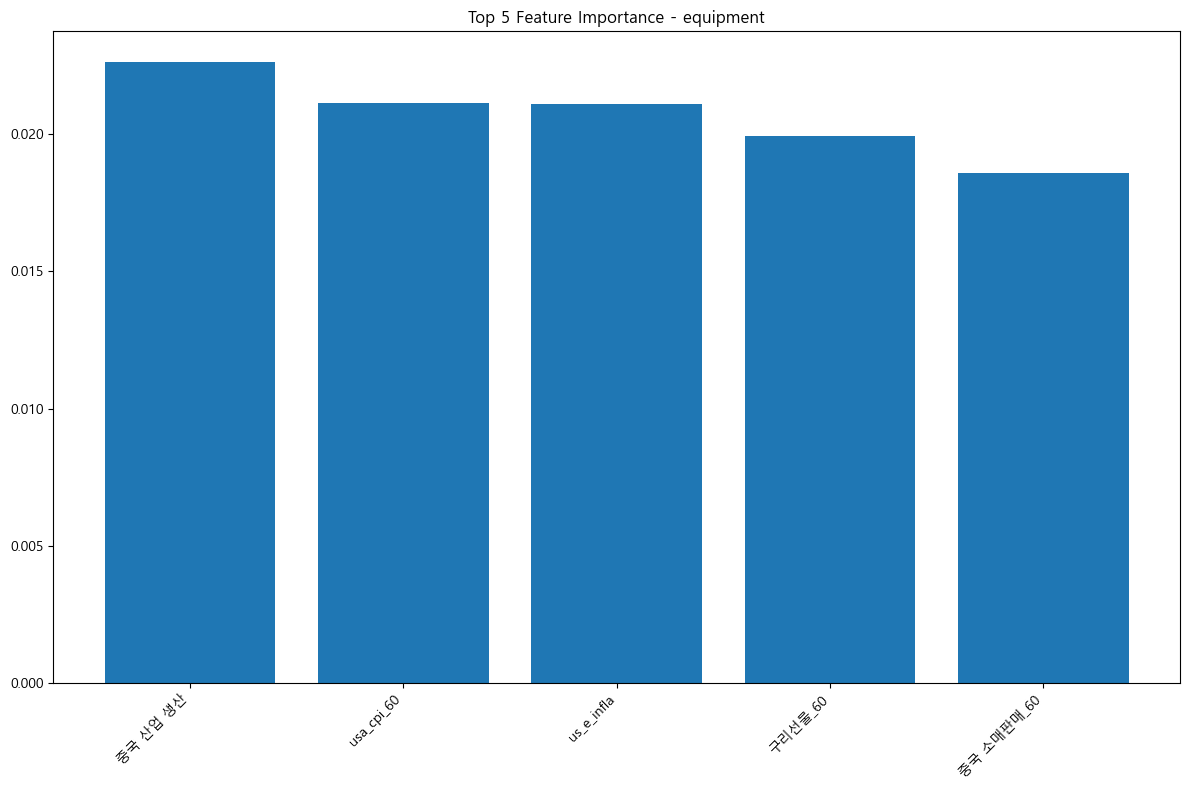

키워드 처리 진행 중:  38%|███▊      | 5/13 [00:48<01:20, 10.10s/it]


처리 중: transport


n_estimators 진행 중: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
조기 종료: 22 에포크에서 종료
조기 종료 모델 - transport: 정확도: 0.8375, 재현율: 0.8091, 정밀도: 0.8070


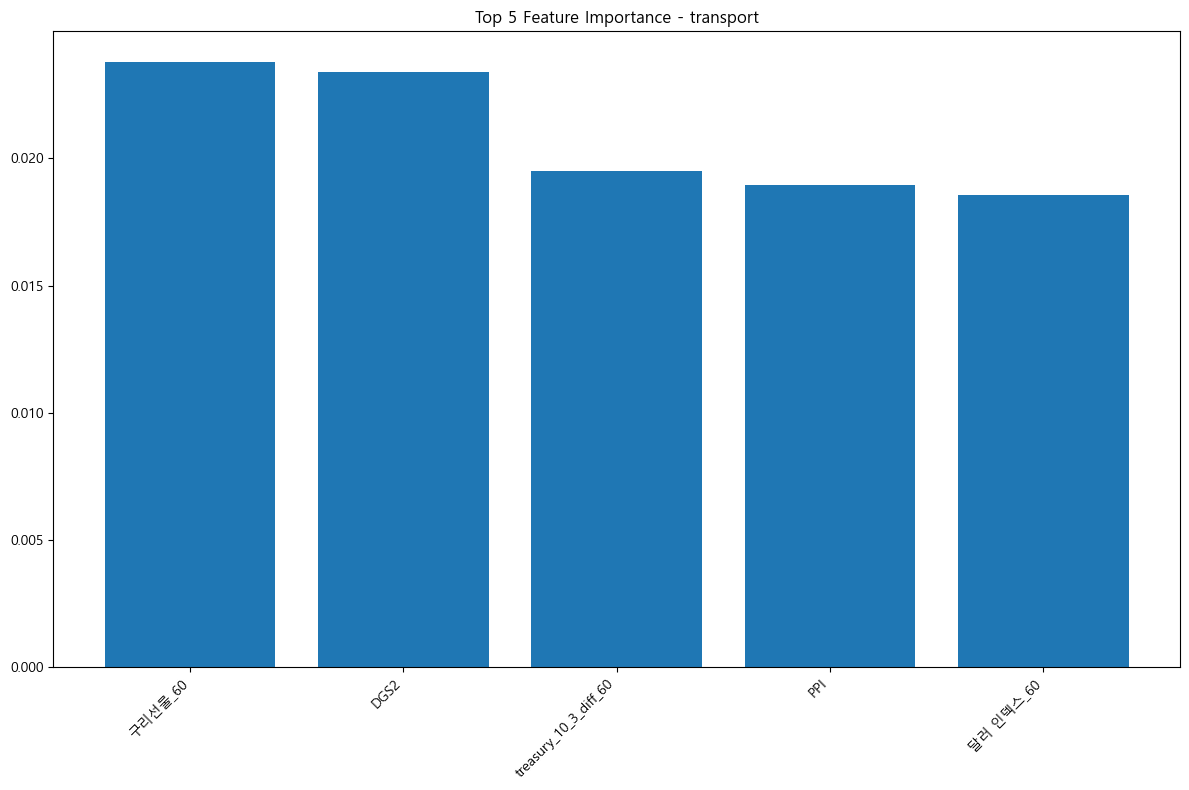

키워드 처리 진행 중:  46%|████▌     | 6/13 [01:01<01:16, 10.91s/it]


처리 중: semi


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 15}
조기 종료: 10 에포크에서 종료
조기 종료 모델 - semi: 정확도: 0.8028, 재현율: 0.7990, 정밀도: 0.7987


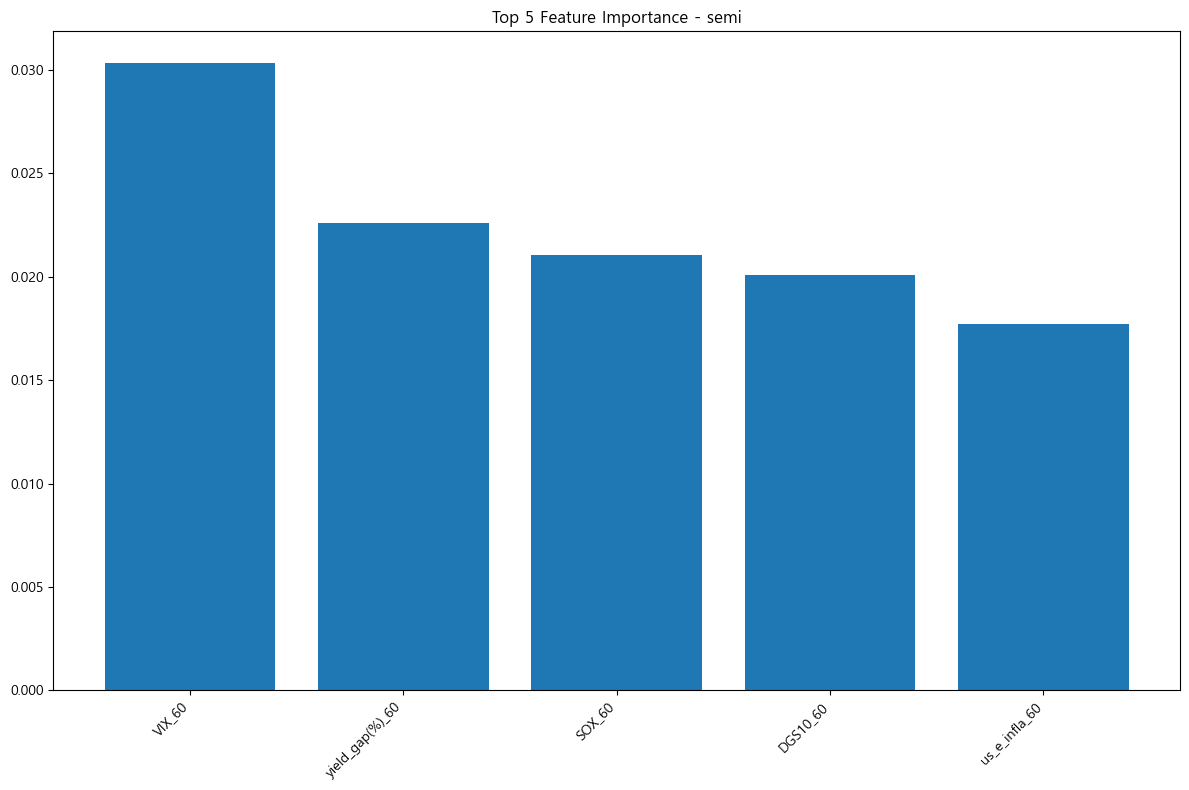

키워드 처리 진행 중:  54%|█████▍    | 7/13 [01:08<00:57,  9.63s/it]


처리 중: bank


n_estimators 진행 중: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


최적 파라미터: {'n_estimators': 10, 'max_depth': 20}
조기 종료: 14 에포크에서 종료
조기 종료 모델 - bank: 정확도: 0.8265, 재현율: 0.8183, 정밀도: 0.8026


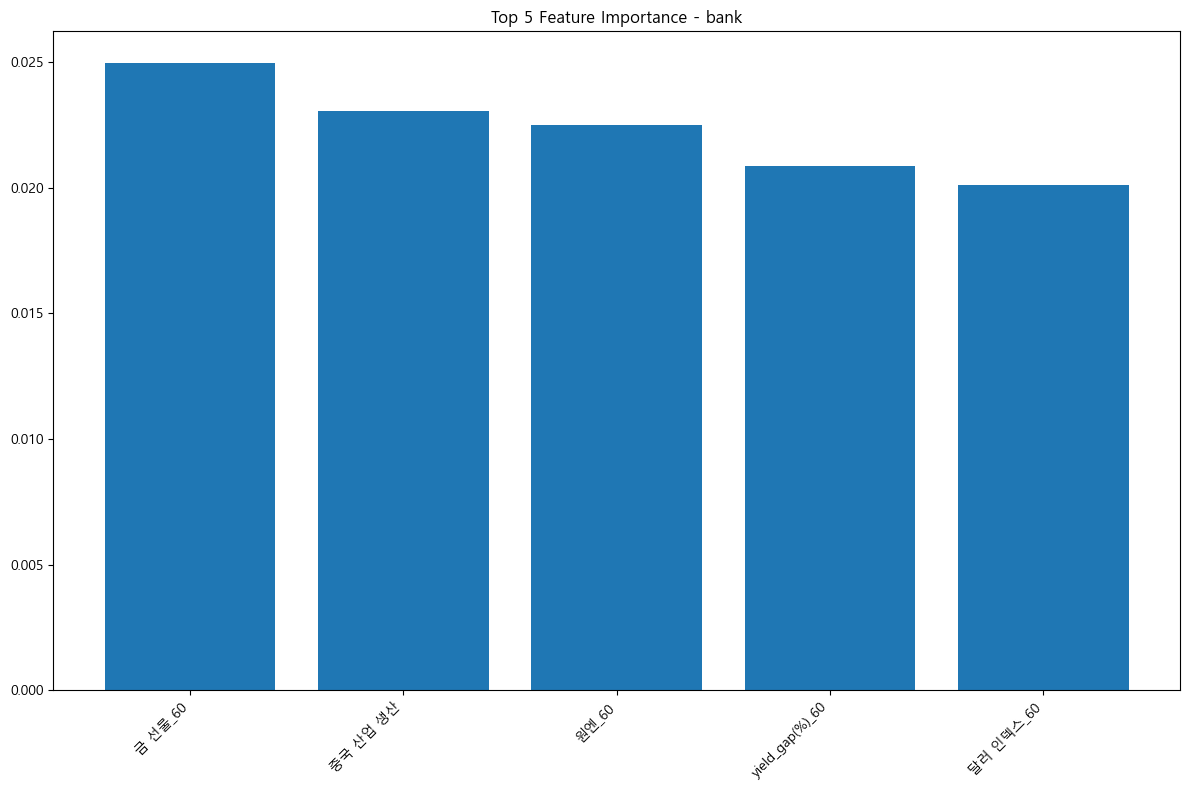

키워드 처리 진행 중:  62%|██████▏   | 8/13 [01:17<00:46,  9.36s/it]


처리 중: steel


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
조기 종료: 17 에포크에서 종료
조기 종료 모델 - steel: 정확도: 0.8391, 재현율: 0.8038, 정밀도: 0.8079


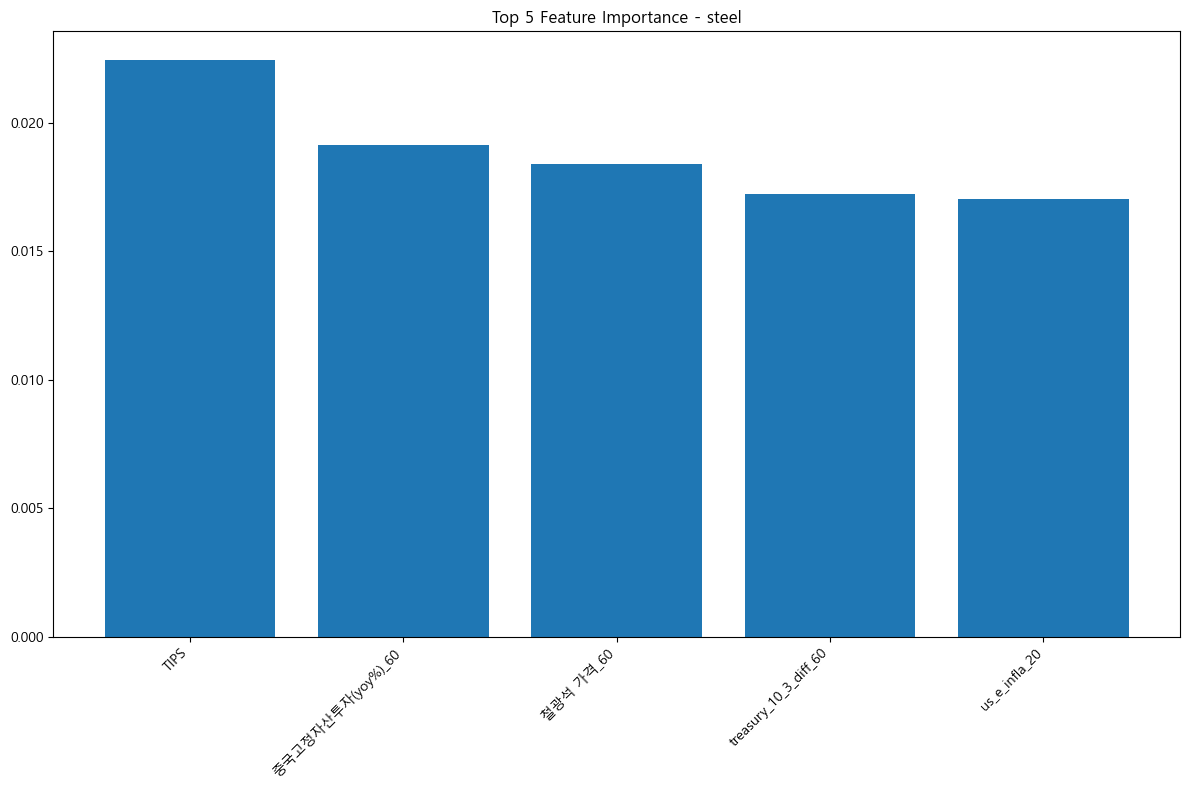

키워드 처리 진행 중:  69%|██████▉   | 9/13 [01:26<00:37,  9.33s/it]


처리 중: telecom


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 15}
조기 종료: 19 에포크에서 종료
조기 종료 모델 - telecom: 정확도: 0.8517, 재현율: 0.8294, 정밀도: 0.8520


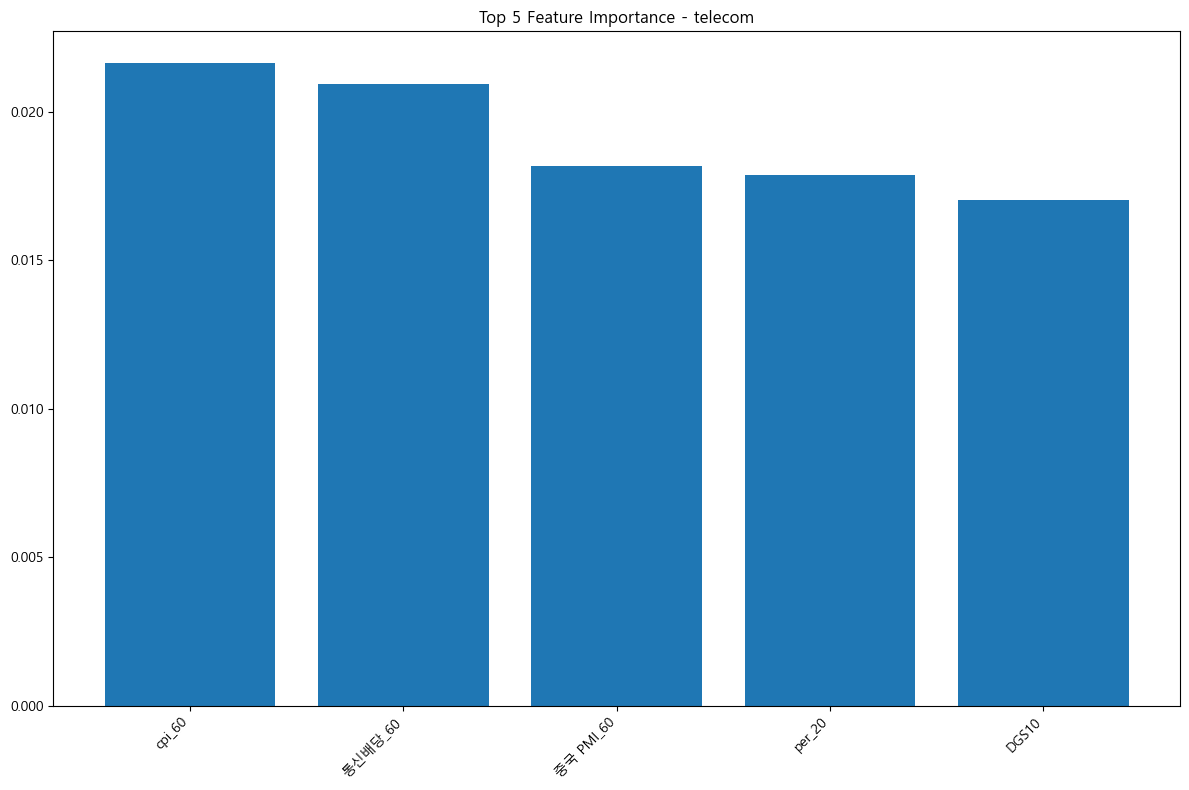

키워드 처리 진행 중:  77%|███████▋  | 10/13 [01:36<00:28,  9.42s/it]


처리 중: staples


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
조기 종료: 29 에포크에서 종료
조기 종료 모델 - staples: 정확도: 0.8691, 재현율: 0.8333, 정밀도: 0.8671


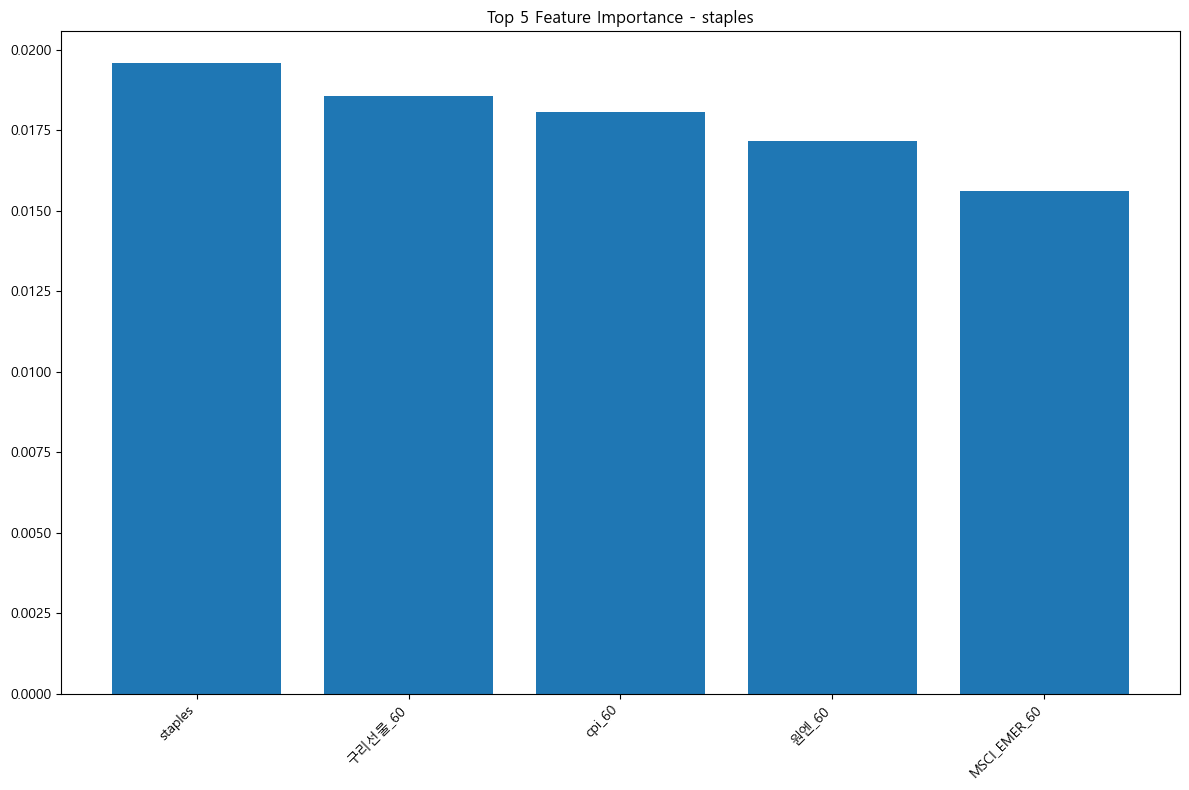

키워드 처리 진행 중:  85%|████████▍ | 11/13 [01:49<00:21, 10.60s/it]


처리 중: discretionary


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
조기 종료: 14 에포크에서 종료
조기 종료 모델 - discretionary: 정확도: 0.8233, 재현율: 0.8163, 정밀도: 0.8098


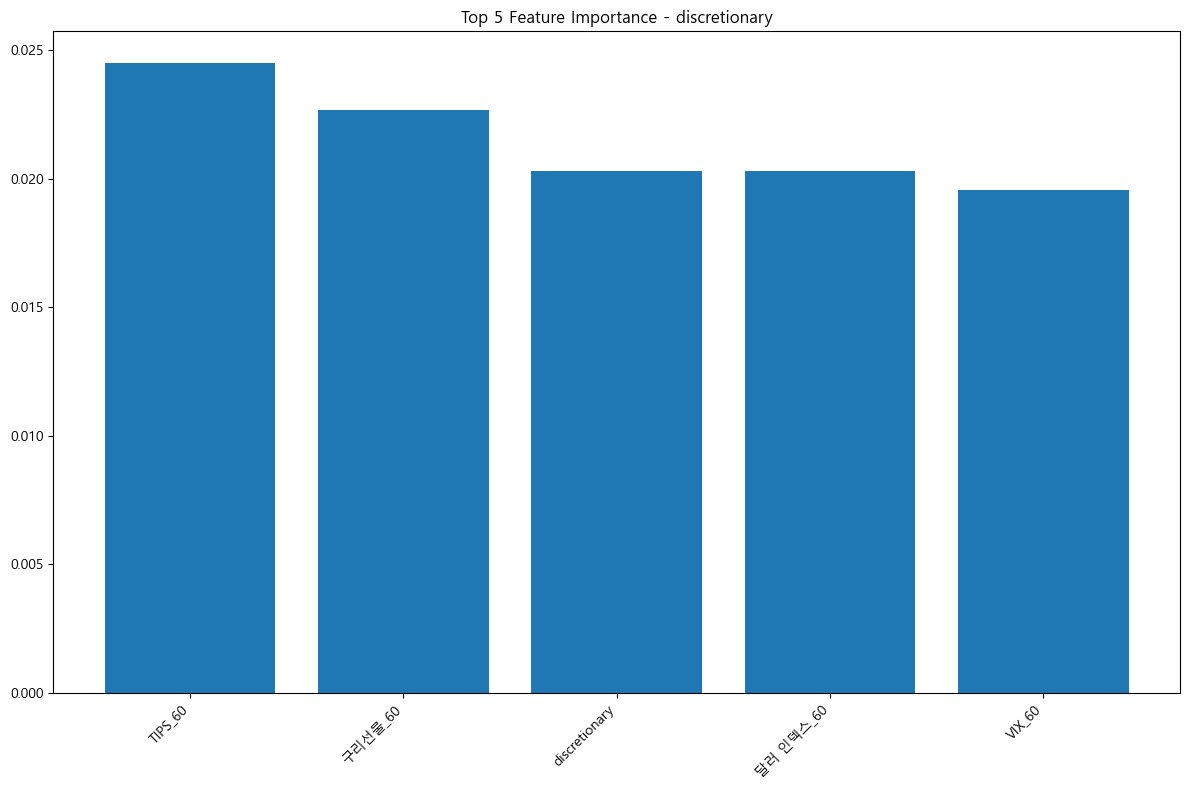

키워드 처리 진행 중:  92%|█████████▏| 12/13 [01:57<00:09,  9.83s/it]


처리 중: kospi


n_estimators 진행 중: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


최적 파라미터: {'n_estimators': 20, 'max_depth': 20}
조기 종료: 12 에포크에서 종료
조기 종료 모델 - kospi: 정확도: 0.8502, 재현율: 0.8258, 정밀도: 0.8482


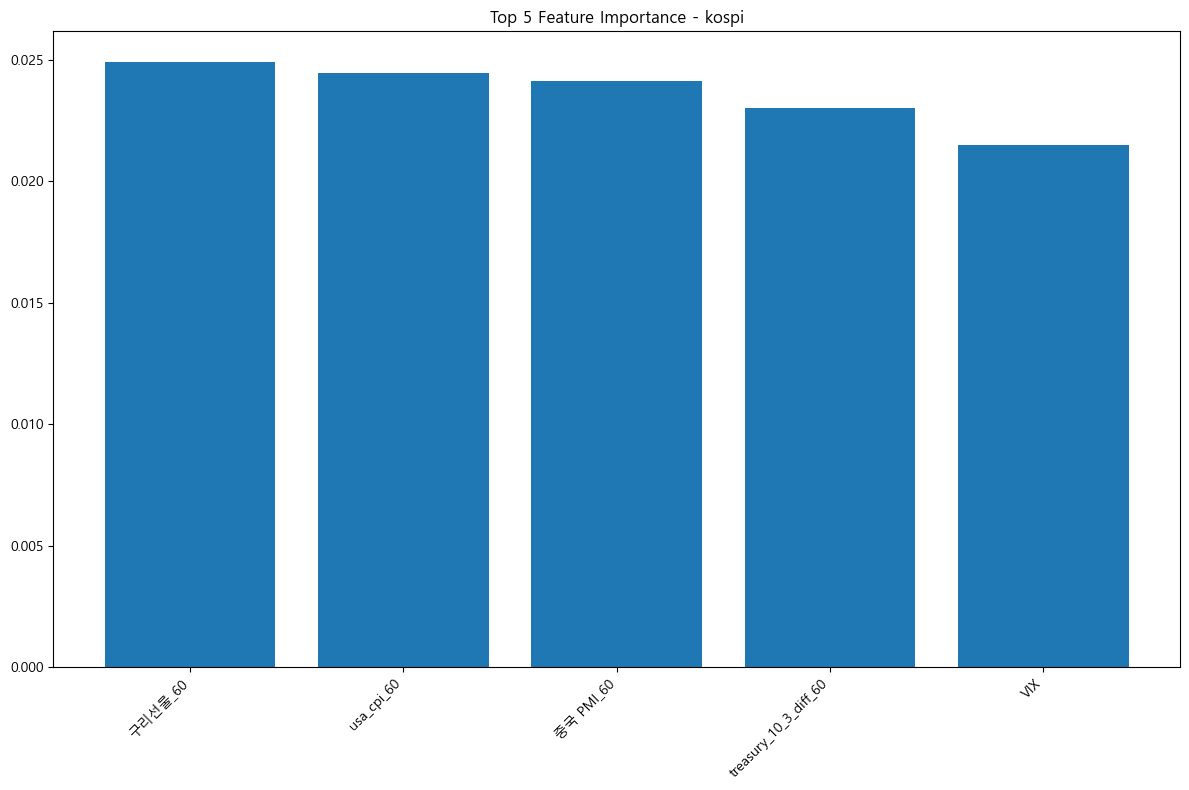

키워드 처리 진행 중: 100%|██████████| 13/13 [02:04<00:00,  9.61s/it]


In [13]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.base import clone
from joblib import dump, load
from tqdm import tqdm
import os

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows에서의 경우
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Ubuntu에서의 경우
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 설정
CONFIG = {
    'input_file': '0703_total.xlsx',
    'output_folder': 'plk_folder_05_1',
    'keywords': ["auto", "construct", "capital_market", "chemicals", "equipment",
                 "transport", "semi", "bank", "steel",
                 "telecom", "staples", "discretionary", "kospi"],
    'window_sizes': [20, 60],
    'n_estimators_range': range(5, 21, 5),  # 하이퍼파라미터 탐색 범위 축소
    'max_depth_range': range(5, 21, 5)  # 하이퍼파라미터 탐색 범위 축소
}

def load_data(file_path, sheet_name):
    """엑셀 파일에서 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=0, index_col=0)
        df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
        return df.dropna()
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

def prepare_data(df, keyword):
    """데이터를 학습용으로 준비합니다."""
    y = df[keyword]
    X = df.drop(columns=[keyword])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test, n_estimators, max_depth):
    """모델을 훈련하고 평가합니다."""
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                 max_leaf_nodes=300, n_jobs=-1, random_state=0)
    rfc.fit(X_train, y_train)
    
    cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')  # 교차 검증 폴드 수 줄이기
    y_pred = rfc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    
    return rfc, cv_scores.mean(), accuracy, recall, precision

def find_best_params(X_train, y_train, n_estimators_range, max_depth_range):
    """최적의 하이퍼파라미터를 찾습니다."""
    best_score = 0
    best_params = {}
    
    for n_estimators in tqdm(n_estimators_range, desc="n_estimators 진행 중"):
        for max_depth in max_depth_range:
            rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                         max_leaf_nodes=300, n_jobs=-1, random_state=0)
            score = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy').mean()  # 교차 검증 폴드 수 줄이기
            
            if score > best_score:
                best_score = score
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
    
    return best_params

def plot_feature_importance(model, feature_names, keyword):
    """특성 중요도를 시각화합니다."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Top 5 Feature Importance - {keyword}')
    plt.bar(range(5), importances[indices][:5])
    plt.xticks(range(5), [feature_names[i] for i in indices[:5]], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def early_stopping_model(X_train, y_train, X_test, y_test, patience=5):
    """조기 종료를 사용한 모델 훈련."""
    best_score = 0
    best_model = RandomForestClassifier(random_state=0)  # 초기화
    no_improvement = 0
    
    model = RandomForestClassifier(random_state=0)
    for i in range(1, 101):
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)
        score = accuracy_score(y_test, model.predict(X_test))
        
        if score > best_score:
            best_score = score
            best_model = clone(model)
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print(f"조기 종료: {i} 에포크에서 종료")
            break
    
    if no_improvement >= patience:
        best_model.fit(X_train, y_train)
    
    return best_model

def main():
    os.makedirs(CONFIG['output_folder'], exist_ok=True)
    
    for keyword in tqdm(CONFIG['keywords'], desc="키워드 처리 진행 중"):
        print(f"\n처리 중: {keyword}")
        
        df = load_data(CONFIG['input_file'], keyword)
        if df is None:
            continue
        
        # 데이터 샘플링 (데이터가 많을 경우 일부만 사용)
        df_sampled = df.sample(frac=0.1, random_state=0) if len(df) > 10000 else df
        
        X_train, X_test, y_train, y_test = prepare_data(df_sampled, keyword)
        
        best_params = find_best_params(X_train, y_train, CONFIG['n_estimators_range'], CONFIG['max_depth_range'])
        print(f"최적 파라미터: {best_params}")
        
        # 조기 종료 모델 학습 및 저장
        early_stopping_rfc = early_stopping_model(X_train, y_train, X_test, y_test)
        
        y_pred = early_stopping_rfc.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
        precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
        
        print(f"조기 종료 모델 - {keyword}: 정확도: {accuracy:.4f}, 재현율: {recall:.4f}, 정밀도: {precision:.4f}")
        
        # 모델 저장
        dump(early_stopping_rfc, f"{CONFIG['output_folder']}/{keyword}_early_stopping_model.pkl")
        
        # 중요도 플롯
        plot_feature_importance(early_stopping_rfc, df.columns, keyword)

if __name__ == "__main__":
    main()
